In [1]:
!python --version

Python 3.7.7


In [2]:
# !pip install spacy
# !pip install scispacy
# !pip install spacy-transformers
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_scibert-0.4.0.tar.gz

# !pip install networkx
# !pip install tqdm
# !pip install grakel
# !pip install seaborn
# !pip install matplotlib
# !pip install numpy
# !pip install -U numpy
# !pip install pandas
# !pip install --upgrade pandas
# !pip install scikit-learn-intelex

In [3]:
###packages
import scispacy
import spacy

import en_core_sci_scibert

from spacy import displacy

import pickle
import time
import os

import numpy as np
import itertools
from itertools import combinations   

import networkx as nx

import pandas as pd
from tqdm import tqdm

import sys
sys.setrecursionlimit(1000000)

import gc

In [4]:
### machine learning-graph kernel(GraKeL)
from __future__ import print_function # >=python2.7
print(__doc__)

%matplotlib inline

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

from grakel.datasets import fetch_dataset
from grakel.utils import cross_validate_Kfold_SVM
from grakel.kernels import WeisfeilerLehman, VertexHistogram

from grakel.utils import graph_from_networkx

# kernels
from grakel.kernels import ShortestPath #Shortest Path Kernel
from grakel.kernels import PropagationAttr #Propagation kernels

#evaluate
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

Automatically created module for IPython interactive environment


In [5]:
### function
    
# save variable：
def save_variable(v,filename):
    f=open(filename,'wb')
    pickle.dump(v,f)
    f.close()
    return filename

# load variable：
def load_variavle(filename):
   f=open(filename,'rb')
   r=pickle.load(f)
   f.close()
   return r

# gene ncbi id in sentence
def gene_in_sentence(sentence): 
    sentence_gene = []
    string = sentence
    while string.find('Gene_')!=-1: #句子還有Gene，就繼續尋找
        sentence = string
        x = sentence.find('Gene_') + 4

        #ID至少1位數，往後找到完整ID 
        l=1
        string = sentence[x+1:]
        while string[:l].isdigit()==True: l+=1    
        ncbi_id_i = string[:l-1]
        sentence_gene.append(ncbi_id_i)
    return list(set(sentence_gene))

# nlp preprocessing
def Display_interaction_Sent(doc,Gene1,Gene2,INTERACTION):
    # Display DNA Entities 
    sent = doc.text[:]

    # POS、Tag
    tt = ""
    pp = ""
    for token in doc:
        if 'Gene' in token.text:
            tt = tt +' '+ token.text
            pp = pp +' '+ token.text
        else:
            tt = tt +' '+ token.tag_
            pp = pp +' '+ token.pos_
            
    print('\033[1m'+'Label :','\033[0m',INTERACTION) #Label
    print('\033[1m'+'Gene pair :','\033[0m',Gene1,Gene2) #Gene pair
    print('\033[1m'+'Sent :','\033[0m',sent) #Sentence
    print('\033[1m'+'Tag Sent:'+'\033[0m',tt)
    print('\033[1m'+'POS Sent:'+'\033[0m',pp,'\n')
      
# Define_Graph
def Define_Graph(doc,path):
    ### Define 'nodes' & 'edges' 
    #(1).define nodes(id)
    nodes = [j for j in range(0,len(doc))]
#     print('\033[1m'+'nodes:','\033[0m'+'\n',nodes)

    #(2).define edges
    edges = []
    for token in doc:
        for child in token.children:
            edges.append((token.i,
                          child.i))
#     print('\033[1m'+'edges:','\033[0m'+'\n',edges)
    
    ### Define 'nodes label' & 'edges label'
    #(3).define nodes_label
    nodes_tag = []
    sdp_tag = []
    for token in doc:
        # nodes tag
        t_tag = token.tag_
        nodes_tag.append(t_tag)
        #shortest path tag
        if token.i in path:
            sdp_tag.append('SDP')
        else:
            sdp_tag.append('NSDP')
        
        
    nodes_label = dict(zip(nodes,list(map(lambda x: np.array(x),zip(nodes_tag,sdp_tag)))))        
#     print('\033[1m'+'nodes_label:','\033[0m')
#     print("\n".join(str(i)+str(nodes_label[i])for i in nodes_label))


    #(4).define edges_label
    #attribute(dep relation, dep direction)******
    dep_direction = []
    Syntax_relation = []
    for p in range(0,len(edges)):
        F = int(edges[p][0])
        C = int(edges[p][1])
        # Direction
        if C > F:
            d = 'Backward' #Backward
            dep_direction.append(d)
        else:
            d = 'Forward' #Forward
            dep_direction.append(d)

        # Syntax
        s = doc[C].dep_
        Syntax_relation.append(s)
    edges_label = dict(zip(edges,list(map(lambda x: np.array(x),zip(dep_direction,Syntax_relation)))))
#     print('\033[1m'+'edges_label:','\033[0m')
#     print("\n".join(str(i)+str(edges_label[i])for i in edges_label))

    #(5).define edges_weight
    #short dep path = 0.9 , 0.1
    weg = []
    for p in range(0,len(edges)):
        F = int(edges[p][0])
        C = int(edges[p][1])

        if C in path and F in path:
            weg.append(0.9)
        else:
            weg.append(0.1)
    edge_weight = dict(zip(edges,weg))
#     print('\033[1m'+'edge_weight:','\033[0m')
#     print(edge_weight)
    
    
    globals()['nodes'] = nodes
    globals()['edges'] = edges
    globals()['nodes_label'] = nodes_label
    globals()['edges_label'] = edges_label
    globals()['edge_weight'] = edge_weight
    
# load spacy model
def load_en_core_sci_scibert_model():
    spacy.prefer_gpu() #use GPU
    nlp = en_core_sci_scibert.load()
    return nlp

# load kegg gene pair
def kegg_gene_pair_fun():
    os.chdir('C:/Users/larry/Desktop/jupyter/Interaction_corpus/kegg_all_gene_pair')
    kegg_gene_pair = pd.read_csv('kegg_gene_pair.csv')
    return kegg_gene_pair

# load kegg gene list
def kegg_gene_list_fun():
    os.chdir('C:/Users/larry/Desktop/jupyter/Interaction_corpus/kegg_all_gene_pair')
    kegg_gene_list = np.load('kegg_gene_list.npy').tolist()
    return kegg_gene_list

# get list index
def get_index(lst=None, item=''):
    return [index for (index,value) in enumerate(lst) if value == item]

# plot ROC curve
def plotROC_AUC(yt, ys):
    '''
    plot ROC-AUC curve
    param yt: True Y
    param ys: Predict Y
    '''
    from sklearn import metrics
    from matplotlib import pyplot as plt
    f_pos, t_pos, thresh = metrics.roc_curve(yt, ys, pos_label=2)
    auc_area = metrics.auc(f_pos, t_pos)

    plt.figure(dpi=300) 
    plt.plot(f_pos, t_pos, 'darkorange', lw=2, label='AUC = %.2f' % auc_area)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def k_fold(s,kernel):
    ### 1.Assign training & validation set
    # (1).fix one set for validation
    x_validation = globals()[f'sub{s}'].Graph
    y_validation = globals()[f'sub{s}'].Label

    # (2).nine set for training
    train = pd.concat([eval(f'sub{n}') for n in range(1,11) if n != s],axis=0).reset_index(drop=True)
    x_train = train.Graph
    y_train = train.Label

    ### 2.10 iterations of training
    # (1).Use the "shortest path kernel" to generate kernel matrices
    gk1 = kernel(normalize=True)
    K1_train = gk1.fit_transform(x_train)
    K1_test = gk1.transform(x_validation)

    # (2).Using SVM classifier for classification
    clf = SVC(kernel="precomputed")
    clf.fit(K1_train, y_train)
    y_pred = clf.predict(K1_test)
    # y_score = clf.fit(K1_train, y_train).decision_function(K1_test)

    # (3).caculate classification accuracy
    acc = accuracy_score(y_validation, y_pred)
    
    # (4).train predict 
    y_pred_train = clf.predict(K1_train)
    acc_train = accuracy_score(y_train, y_pred_train)
    
    print(f"{s} iter Accuracy(train,test):", str(round(acc_train*100, 2)) + "%", str(round(acc*100, 2)) + "%")
    return acc_train,acc

def k_fold_fast(s,kernel):
    from sklearnex import patch_sklearn
    patch_sklearn()

    from sklearn.svm import SVC
    
    
    ### 1.Assign training & validation set
    # (1).fix one set for validation
    x_validation = globals()[f'sub{s}'].Graph
    y_validation = globals()[f'sub{s}'].Label

    # (2).nine set for training
    train = pd.concat([eval(f'sub{n}') for n in range(1,11) if n != s],axis=0).reset_index(drop=True)
    x_train = train.Graph
    y_train = train.Label

    ### 2.10 iterations of training
    # (1).Use the "shortest path kernel" to generate kernel matrices
    gk1 = kernel(normalize=True)
    K1_train = gk1.fit_transform(x_train)
    K1_test = gk1.transform(x_validation)

    # (2).Using SVM classifier for classification
    clf = SVC(kernel="precomputed")
    clf.fit(K1_train, y_train)
    y_pred = clf.predict(K1_test)
    # y_score = clf.fit(K1_train, y_train).decision_function(K1_test)

    # (3).caculate classification accuracy
    acc = accuracy_score(y_validation, y_pred)
    
    # (4).train predict 
    y_pred_train = clf.predict(K1_train)
    acc_train = accuracy_score(y_train, y_pred_train)
    
    print(f"{s} iter Accuracy(train,test):", str(round(acc_train*100, 2)) + "%", str(round(acc*100, 2)) + "%")
    return acc_train,acc

def result_validation(kernel):
    # (1).Test
    x_validation = TEST.Graph
    y_validation = TEST.Label

    # (2).Training
    x_train = TRAIN.Graph
    y_train = TRAIN.Label

    # (3).Use the "shortest path kernel" to generate kernel matrices
    gk1 = kernel(normalize=True)
    K1_train = gk1.fit_transform(x_train)
    K1_test = gk1.transform(x_validation)

    # (4).Using SVM classifier for classification
    clf = SVC(kernel="precomputed")
    clf.fit(K1_train, y_train)
    y_pred = clf.predict(K1_test)
    # y_score = clf.fit(K1_train, y_train).decision_function(K1_test)

    # (5).caculate classification accuracy
    acc = accuracy_score(y_validation, y_pred)

    # (6).train predict 
    y_pred_train = clf.predict(K1_train)
    acc_train = accuracy_score(y_train, y_pred_train)

    print(f"{s} iter Accuracy(train,test):", str(round(acc_train*100, 2)) + "%", str(round(acc*100, 2)) + "%")
    return acc_train,acc


Reference page URL:
1. pandas speed up : https://www.jianshu.com/p/ac339a8ea0d0
2. pandas speed up result : https://blog.csdn.net/weixin_33848436/article/details/112523562?utm_medium=distribute.pc_relevant.none-task-blog-baidujs_title-0&spm=1001.2101.3001.4242
2. grakel.graph_from_networkx : https://ysig.github.io/GraKeL/0.1a8/generated/grakel.graph_from_networkx.html
4. roc curve : https://blog.csdn.net/pipisorry/article/details/53001866

# DS corpus

## data

In [60]:
Path = 'C:/Users/larry/Desktop/jupyter/DS_corpus'
allFileList = os.listdir(Path)
allFileList

['Range_0_12999.npy',
 'Range_104000_116999.npy',
 'Range_104496_116999.npy',
 'Range_105039_116999.npy',
 'Range_105897_116999.npy',
 'Range_106973_116999.npy',
 'Range_108453_116999.npy',
 'Range_115186_116999.npy',
 'Range_115813_116999.npy',
 'Range_117000_130870.npy',
 'Range_118197_130870.npy',
 'Range_118356_130870.npy',
 'Range_119027_130870.npy',
 'Range_120083_130870.npy',
 'Range_120186_130870.npy',
 'Range_120212_130870.npy',
 'Range_124271_130870.npy',
 'Range_13000_25999.npy',
 'Range_14454_25999.npy',
 'Range_15180_25999.npy',
 'Range_17601_25999.npy',
 'Range_23509_25999.npy',
 'Range_26000_38999.npy',
 'Range_26297_38999.npy',
 'Range_26505_38999.npy',
 'Range_26675_38999.npy',
 'Range_29688_38999.npy',
 'Range_3189_12999.npy',
 'Range_33212_38999.npy',
 'Range_36889_38999.npy',
 'Range_37736_38999.npy',
 'Range_39000_51999.npy',
 'Range_39220_51999.npy',
 'Range_39285_51999.npy',
 'Range_39385_51999.npy',
 'Range_41894_51999.npy',
 'Range_44795_51999.npy',
 'Range_520

In [61]:
# load all result
df_list = []
for file in allFileList:
    os.chdir('C:/Users/larry/Desktop/jupyter/DS_corpus')
    try:
        arr=np.load(file,allow_pickle=True)
    except OSError:
        arr=np.loadtxt(file)
        
    df_list = df_list + arr.tolist()

In [62]:
len(df_list)

591314

In [63]:
pre_df = pd.DataFrame(df_list,columns = ["PMID" ,"LOCATION","SENTENCE" ,"GENE1" ,"GENE2" ,"INTERACTION"])
DS_corpus_kegg = pre_df.loc[pre_df.astype(str).drop_duplicates().index].reset_index().drop(["index"], axis=1)

## get label

In [64]:
# kegg genes pair list
os.chdir('C:/Users/larry/Desktop/jupyter/Interaction_corpus/kegg_all_gene_pair')
kegg_gene_pair = pd.read_csv('kegg_gene_pair.csv')

pair_list = []
for kgp in kegg_gene_pair.index:
    C = kegg_gene_pair.loc[kgp,['gene_1_id','gene_2_id']].astype(str).to_list()
    pair_list.append(set(C))

print(f'knowledge database : {len(pair_list)} gene pair')

knowledge database : 11365 gene pair


In [65]:
# git label for sentence
Labels = []
for i in tqdm(DS_corpus_kegg.index):
    sent_p = set(DS_corpus_kegg.loc[i,['GENE1','GENE2']].astype(str).to_list())
    if sent_p in pair_list:
        label = 'KEGG_Interaction'
    else:
        label = 'NON_KEGG_Interaction'
    Labels.append(label)

    
DS_corpus_kegg['INTERACTION'] = Labels

100%|████████████████████████████████████████████████████████████████████████| 392725/392725 [04:46<00:00, 1370.44it/s]


### save data

In [14]:
%cd /home/tku_stat_dell/Desktop/DS_corpus
!ls

/home/tku_stat_dell/Desktop/DS_corpus
DS_Classifier.ipynb  DS_corpus_kegg.csv  DS_corpus_kegg_graph_data


In [6]:
# # save1
# DS_corpus_kegg.to_csv(r'C:/Users/larry/Desktop/jupyter/Interaction_corpus/DS_corpus/DS_corpus_kegg.csv', index=False)
# # load1
# DS = pd.read_csv('DS_corpus_kegg.csv')
# # Normalized data
# DS_corpus1 = DS.dropna(axis=0,how='any')[:]
# DS_corpus1[['GENE1','GENE2']] = DS_corpus1[['GENE1','GENE2']].astype(int).astype(str)
# DS_corpus2 = DS_corpus1.reset_index().drop(["index"], axis=1)
# # save1
# DS_corpus2.to_csv(r'C:/Users/larry/Desktop/jupyter/Interaction_corpus/DS_corpus/DS_corpus_kegg.csv', index=False)

In [6]:
# load1
DS_corpus_kegg = pd.read_csv('DS_corpus_kegg.csv')

In [7]:
DS_corpus_kegg

,PMID,LOCATION,SENTENCE,GENE1,GENE2,INTERACTION
0,28059022,"[58, 91]",The emergence of ASIA syndrome is associated w...,3126,3123,NON_KEGG_Interaction
1,31132167,"[46, 94]",Focused Sanger sequencing from genomic DNA was...,3039,2034,NON_KEGG_Interaction
2,31132167,"[46, 94]",Focused Sanger sequencing from genomic DNA was...,3039,54583,NON_KEGG_Interaction
3,31132167,"[46, 94]",Focused Sanger sequencing from genomic DNA was...,3039,3040,NON_KEGG_Interaction
4,31132167,"[46, 94]",Focused Sanger sequencing from genomic DNA was...,3039,2057,NON_KEGG_Interaction
...,...,...,...,...,...,...
392713,18802702,"[60, 119]","The kegg_Gene_4312 -1,607 1G/2G (rs1799750), k...",4312,4313,NON_KEGG_Interaction
392714,18802702,"[119, 141]",Genotype distributions and allele frequencies ...,4312,4313,NON_KEGG_Interaction
392715,17932346,"[0, 21]",Comprehensive association analysis of the vita...,1594,1591,NON_KEGG_Interaction
392716,17932346,"[37, 84]",We studied the association between polymorphis...,1594,1591,NON_KEGG_Interaction


In [8]:
print('Gene-Gene Interaction:',DS_corpus_kegg.INTERACTION.value_counts()['KEGG_Interaction'])
print('Not Gene-Gene Interaction:',DS_corpus_kegg.INTERACTION.value_counts()['NON_KEGG_Interaction'])

Gene-Gene Interaction: 14066
Not Gene-Gene Interaction: 378652


# construct graph

In [9]:
spacy.prefer_gpu() #use GPU
nlp = en_core_sci_scibert.load()

## Graphic feature extraction(define graph)
Syntactic dependency & POS tag & shortest dependency path



In [35]:
### Graphic feature extraction
#save time
PMID_list = DS_corpus_kegg['PMID'].to_list()[:]
LOCATION_list = DS_corpus_kegg['LOCATION'].to_list()[:]
doc_list = DS_corpus_kegg['SENTENCE'].to_list()[:]
Gene1_list = DS_corpus_kegg['GENE1'].to_list()[:]
Gene2_list = DS_corpus_kegg['GENE2'].to_list()[:]
INTERACTION_list = DS_corpus_kegg['INTERACTION'].to_list()[:]


#start

G_all = []
for n in tqdm(DS_corpus_kegg.index): # long time, big!!!
#     print("{:=^100s}".format(str(n)))

    ### 0.get gene interaction pair & sentence
#     print('\033[1m'+'PMID :','\033[0m', PMID_list[n], LOCATION_list[n]) #PMID
    doc = nlp(doc_list[n])
    Gene1 = Gene1_list[n]
    Gene2 = Gene2_list[n]
    INTERACTION = INTERACTION_list[n]
#     print('\033[1m'+'Sent :','\033[0m',doc) #Sentence

    ### 1.Graphic feature extraction(dependency relation & token tag & shorteat path)      
    edges = []
    for token in doc:
        # two gene location in sent
        if f'Gene_{Gene1}' in token.text:
            entity1 = token.i
        if f'Gene_{Gene2}' in token.text:
            entity2 = token.i
        # sent id graph
        for child in token.children:
            edges.append((token.i,
                          child.i))    
    G = nx.Graph(edges)


    # shortest path
    try:
        distance=nx.shortest_path_length(G, source=entity1, target=entity2)
#         print(f'Gene {Gene1} to {Gene2} distance：', distance)
        path=nx.shortest_path(G, source=entity1, target=entity2)
#         print(f'Gene {Gene1} to {Gene2} path：', path,'\n')
    except nx.NetworkXNoPath:
#         print('The shortest path between entities is not exist!!! The two are not related, skip')
        continue
    except nx.NodeNotFound:
#         print('Program problem, can be improved, skip first') #Gene ID indicates error
        continue
        
    if len(path)==2: # The shortest path between entities is adjacent! Non-interaction
#         print('The shortest path between entities is adjacent!!! Non-interaction')
        path = []
        ## define sentence to graph
        Define_Graph(doc,path)
        ## construct NetworkX graph by GraKel format
        G1 = nx.Graph()
        G1.add_nodes_from(nodes)
        G1.add_edges_from(edges, weight=3)
        nx.set_node_attributes(G1,nodes_label,'label')
        nx.set_edge_attributes(G1,edges_label,'attributes')
        nx.set_edge_attributes(G1,edge_weight,'weight')

        G_nx.append(G1)
        G_Label.append('NON_KEGG_Interaction')
        G_sent.append(doc.text)
        G_all.append([doc.text,G1,Gene1,Gene2,entity1,entity2,'NON_KEGG_Interaction'])
    else:
#         print('Successfully constructed graphics')
        ## define sentence to graph
        Define_Graph(doc,path)
        ## construct NetworkX graph
        G1 = nx.Graph()
        G1.add_nodes_from(nodes)
        G1.add_edges_from(edges, weight=3)
        nx.set_node_attributes(G1,nodes_label,'label')
        nx.set_edge_attributes(G1,edges_label,'attributes')
        nx.set_edge_attributes(G1,edge_weight,'weight')

        G_all.append([doc.text,G1,Gene1,Gene2,entity1,entity2,INTERACTION])
#         print('\n')

100%|██████████| 392718/392718 [10:35:39<00:00, 10.30it/s]   


In [36]:
DS_corpus_kegg_graph_data=pd.DataFrame(G_all,columns = ["sent" ,"graph","Gene1" ,"Gene2" ,"Gene1_loc" ,"Gene2_loc","Label"])

DS_corpus_kegg_graph_data

,sent,graph,Gene1,Gene2,Gene1_loc,Gene2_loc,Label
0,The emergence of ASIA syndrome is associated w...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",3126,3123,20,16,NON_KEGG_Interaction
1,Focused Sanger sequencing from genomic DNA was...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",3039,2034,42,30,NON_KEGG_Interaction
2,Focused Sanger sequencing from genomic DNA was...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",3039,54583,42,22,NON_KEGG_Interaction
3,Focused Sanger sequencing from genomic DNA was...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",3039,3040,42,45,NON_KEGG_Interaction
4,Focused Sanger sequencing from genomic DNA was...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",3039,2057,42,9,NON_KEGG_Interaction
...,...,...,...,...,...,...,...
392364,"The kegg_Gene_4312 -1,607 1G/2G (rs1799750), k...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",4312,4313,1,9,NON_KEGG_Interaction
392365,Genotype distributions and allele frequencies ...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",4312,4313,6,8,NON_KEGG_Interaction
392366,Comprehensive association analysis of the vita...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1594,1591,12,15,NON_KEGG_Interaction
392367,We studied the association between polymorphis...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1594,1591,24,31,NON_KEGG_Interaction


In [40]:
print('Gene-Gene Interaction:',DS_corpus_kegg_graph_data.Label.value_counts()['KEGG_Interaction'])
print('Not Gene-Gene Interaction:',DS_corpus_kegg_graph_data.Label.value_counts()['NON_KEGG_Interaction'])

Gene-Gene Interaction: 10500
Not Gene-Gene Interaction: 381869


## save variable

In [49]:
%cd /home/tku_stat_dell/Desktop/DS_corpus/DS_corpus_kegg_graph_data
!ls

/home/tku_stat_dell/Desktop/DS_corpus/DS_corpus_kegg_graph_data


In [50]:
#save df(split)
DS_corpus_kegg_graph_data[:130789].to_pickle('DS_corpus_kegg_graph_data_1.pkl')

In [51]:
#save df(split)
DS_corpus_kegg_graph_data[130789:261578].to_pickle('DS_corpus_kegg_graph_data_2.pkl')

In [52]:
#save df(split)
DS_corpus_kegg_graph_data[261578:].to_pickle('DS_corpus_kegg_graph_data_3.pkl')

In [53]:
len(DS_corpus_kegg_graph_data)

392369

## load variable

In [6]:
%cd /home/tku_stat_dell/Desktop/DS_corpus/DS_corpus_kegg_graph_data
!ls

/home/tku_stat_dell/Desktop/DS_corpus/DS_corpus_kegg_graph_data
DS_corpus_kegg_graph_data_1.pkl  ML_data.pkl	    ML_data_sdp_3.pkl
DS_corpus_kegg_graph_data_2.pkl  ML_data_sdp_1.pkl
DS_corpus_kegg_graph_data_3.pkl  ML_data_sdp_2.pkl


In [7]:
### Load final result( graph df(.pkl) )
%cd /home/tku_stat_dell/Desktop/DS_corpus/DS_corpus_kegg_graph_data
data_1 = pd.read_pickle('DS_corpus_kegg_graph_data_1.pkl')
print('1 done')
data_2 = pd.read_pickle('DS_corpus_kegg_graph_data_2.pkl')
print('2 done')
data_3 = pd.read_pickle('DS_corpus_kegg_graph_data_3.pkl')

/home/tku_stat_dell/Desktop/DS_corpus/DS_corpus_kegg_graph_data
1 done
2 done


In [8]:
DS_corpus_kegg_graph_data = pd.concat([data_1,data_2,data_3],axis=0)
del data_1,data_2,data_3
gc.collect()

40

In [9]:
DS_corpus_kegg_graph_data

,sent,graph,Gene1,Gene2,Gene1_loc,Gene2_loc,Label
0,The emergence of ASIA syndrome is associated w...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",3126,3123,20,16,NON_KEGG_Interaction
1,Focused Sanger sequencing from genomic DNA was...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",3039,2034,42,30,NON_KEGG_Interaction
2,Focused Sanger sequencing from genomic DNA was...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",3039,54583,42,22,NON_KEGG_Interaction
3,Focused Sanger sequencing from genomic DNA was...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",3039,3040,42,45,NON_KEGG_Interaction
4,Focused Sanger sequencing from genomic DNA was...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",3039,2057,42,9,NON_KEGG_Interaction
...,...,...,...,...,...,...,...
392364,"The kegg_Gene_4312 -1,607 1G/2G (rs1799750), k...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",4312,4313,1,9,NON_KEGG_Interaction
392365,Genotype distributions and allele frequencies ...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",4312,4313,6,8,NON_KEGG_Interaction
392366,Comprehensive association analysis of the vita...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1594,1591,12,15,NON_KEGG_Interaction
392367,We studied the association between polymorphis...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1594,1591,24,31,NON_KEGG_Interaction


In [9]:
print('Gene-Gene Interaction:',DS_corpus_kegg_graph_data.Label.value_counts()['KEGG_Interaction'])
print('Not Gene-Gene Interaction:',DS_corpus_kegg_graph_data.Label.value_counts()['NON_KEGG_Interaction'])

Gene-Gene Interaction: 10500
Not Gene-Gene Interaction: 381869


## define graph(try adjust)

In [30]:
### Graphic feature extraction
#save time
PMID_list = DS_corpus_kegg['PMID'].to_list()[:]
LOCATION_list = DS_corpus_kegg['LOCATION'].to_list()[:]
doc_list = DS_corpus_kegg['SENTENCE'].to_list()[:]
Gene1_list = DS_corpus_kegg['GENE1'].to_list()[:]
Gene2_list = DS_corpus_kegg['GENE2'].to_list()[:]
INTERACTION_list = DS_corpus_kegg['INTERACTION'].to_list()[:]

### 0.get gene interaction pair & sentence
doc = nlp(doc_list[n])
Gene1 = Gene1_list[n]
Gene2 = Gene2_list[n]
INTERACTION = INTERACTION_list[n]

Display_interaction_Sent(doc,Gene1,Gene2,INTERACTION)

# Display Dependency graph
displacy.render(doc, style='dep',options={'compact':True}, jupyter=True)

Label :  NON_KEGG_Interaction
Gene pair :  54583 3040
Sent :  Focused Sanger sequencing from genomic DNA was performed for kegg_Gene_2057 (exon 8), VHL (exons 2-3), kegg_Gene_54583 (exons 2-5), kegg_Gene_2034 (exon 12), and all exons of kegg_Gene_3043, kegg_Gene_3039, and kegg_Gene_3040 genes.
Tag Sent:  JJ NN NN IN JJ NN VBD VBN IN kegg_Gene_2057 -LRB- NN -RRB- , NN -LRB- NNS CD SYM CD -RRB- , kegg_Gene_54583 -LRB- NNS CD SYM CD -RRB- , kegg_Gene_2034 -LRB- NN CD -RRB- , CC DT NNS IN kegg_Gene_3043 , kegg_Gene_3039 , CC kegg_Gene_3040 NNS .
POS Sent:  ADJ NOUN NOUN ADP ADJ NOUN VERB VERB ADP kegg_Gene_2057 PUNCT NOUN PUNCT PUNCT NOUN PUNCT NOUN NUM SYM NUM PUNCT PUNCT kegg_Gene_54583 PUNCT NOUN NUM SYM NUM PUNCT PUNCT kegg_Gene_2034 PUNCT NOUN NUM PUNCT PUNCT CCONJ DET NOUN ADP kegg_Gene_3043 PUNCT kegg_Gene_3039 PUNCT CCONJ kegg_Gene_3040 NOUN PUNCT 



In [31]:
#start
G_nx = []
G_Label = []


### 1.Graphic feature extraction(dependency relation & token tag & shorteat path)      
edges = []
for token in doc:
    # two gene location in sent
    if f'Gene_{Gene1}' in token.text:
        entity1 = token.i
    if f'Gene_{Gene2}' in token.text:
        entity2 = token.i
    # sent id graph
    for child in token.children:
        edges.append((token.i,
                      child.i))    
G = nx.Graph(edges)


# shortest path
try:
    distance=nx.shortest_path_length(G, source=entity1, target=entity2)
    print(f'Gene {Gene1} to {Gene2} distance：', distance)
    path=nx.shortest_path(G, source=entity1, target=entity2)
    print(f'Gene {Gene1} to {Gene2} path：', path,'\n')
except nx.NetworkXNoPath:
    print('The shortest path between entities is not exist!!! The two are not related, skip')
except nx.NodeNotFound:
    print('Program problem, can be improved, skip first')

# if len(path)==2: # The shortest path between entities is adjacent! Non-interaction
#     print('The shortest path between entities is adjacent!!! Non-interaction')
#     path = []
#     ## define sentence to graph
#     Define_Graph(doc,path)
#     ## construct NetworkX graph by GraKel format
#     G1 = nx.Graph()
#     G1.add_nodes_from(nodes)
#     G1.add_edges_from(edges, weight=3)
#     nx.set_node_attributes(G1,nodes_label,'label')
#     nx.set_edge_attributes(G1,edges_label,'attributes')
#     nx.set_edge_attributes(G1,edge_weight,'weight')

#     G_nx.append(G1)
#     G_Label.append('NON_KEGG_Interaction')
# else:
#     print('Successfully constructed graphics')
#     ## define sentence to graph
#     Define_Graph(doc,path)
#     ## construct NetworkX graph
#     G1 = nx.Graph()
#     G1.add_nodes_from(nodes)
#     G1.add_edges_from(edges, weight=3)
#     nx.set_node_attributes(G1,nodes_label,'label')
#     nx.set_edge_attributes(G1,edges_label,'attributes')
#     nx.set_edge_attributes(G1,edge_weight,'weight')

#     G_nx.append(G1)
#     G_Label.append(INTERACTION)
#     print('\n')

Gene 54583 to 3040 distance： 5
Gene 54583 to 3040 path： [22, 14, 9, 38, 40, 45] 



# Graph classification(GraKeL)

## NetworkX graph -> GraKeL 格式

### features adjust

In [10]:
# NetworkX graph -> GraKeL format
G_nx = DS_corpus_kegg_graph_data.graph
G_k = graph_from_networkx(G_nx, edge_labels_tag='attributes',
                          node_labels_tag='label',
                          edge_weight_tag='weight') #edge_weight_tag

In [11]:
# translate features
G = list(G_k)[:]
for k in tqdm(range(len(G))):
    #node get only one attr (tag)
    a1 = G[k][1] 
    b1 = list(map(lambda x: G[k][1][x][0], a1))
    G[k][1] = dict(zip(a1,b1))
    
    #weight : 0.1-->0.3
    G[k][0] = eval(str(G[k][0]).replace('0.1','0.3'))

100%|██████████| 392369/392369 [03:08<00:00, 2080.34it/s]


### display feature

In [12]:
print("\n 1.edge_weight_tag , 2.node_labels_tag , 3.edge_labels_tag")
G[:10]


 1.edge_weight_tag , 2.node_labels_tag , 3.edge_labels_tag


[[{0: {1: 0.3},
   1: {0: 0.3, 4: 0.3, 6: 0.3},
   2: {4: 0.3},
   3: {4: 0.3},
   4: {1: 0.3, 2: 0.3, 3: 0.3},
   5: {6: 0.3},
   6: {1: 0.3, 5: 0.3, 10: 0.3, 32: 0.3},
   7: {10: 0.3},
   8: {10: 0.3},
   9: {10: 0.3},
   10: {6: 0.3, 7: 0.3, 8: 0.3, 9: 0.3, 11: 0.3, 13: 0.3, 14: 0.3},
   11: {10: 0.3},
   12: {13: 0.3},
   13: {10: 0.3, 12: 0.3},
   14: {10: 0.3, 15: 0.3, 21: 0.3, 22: 0.3},
   15: {14: 0.3, 16: 0.3},
   16: {15: 0.3, 17: 0.3, 18: 0.3, 19: 0.3, 20: 0.3},
   17: {16: 0.3},
   18: {16: 0.3},
   19: {16: 0.3},
   20: {16: 0.3},
   21: {14: 0.3},
   22: {14: 0.3, 24: 0.3},
   23: {24: 0.3},
   24: {22: 0.3, 23: 0.3, 29: 0.3},
   25: {29: 0.3},
   26: {27: 0.3, 28: 0.3, 29: 0.3},
   27: {26: 0.3},
   28: {26: 0.3},
   29: {24: 0.3, 25: 0.3, 26: 0.3, 30: 0.3},
   30: {29: 0.3, 31: 0.3},
   31: {30: 0.3},
   32: {6: 0.3}},
  {0: 'DT',
   1: 'NN',
   2: 'IN',
   3: 'NN',
   4: 'NN',
   5: 'VBZ',
   6: 'VBN',
   7: 'IN',
   8: 'JJ',
   9: 'JJ',
   10: 'NN',
   11: ',',
   12:

In [13]:
del G_k
gc.collect()

127

In [15]:
ML_data = pd.DataFrame({"Sent":DS_corpus_kegg_graph_data.sent,
                        "Graph":G,
                        "Gene1":DS_corpus_kegg_graph_data.Gene1,
                        "Gene2":DS_corpus_kegg_graph_data.Gene2,
                        "Gene1_loc":DS_corpus_kegg_graph_data.Gene1_loc,
                        "Gene2_loc":DS_corpus_kegg_graph_data.Gene2_loc,
                        "Label":DS_corpus_kegg_graph_data.Label})

#### save

In [24]:
# save graph df(.pkl)
%cd /home/tku_stat_dell/Desktop/DS_corpus/DS_corpus_kegg_graph_data
ML_data[:130789].to_pickle('ML_data_sdp_1.pkl')

/home/tku_stat_dell/Desktop/DS_corpus/DS_corpus_kegg_graph_data


In [25]:
%cd /home/tku_stat_dell/Desktop/DS_corpus/DS_corpus_kegg_graph_data
ML_data[130789:261578].to_pickle('ML_data_sdp_2.pkl')

/home/tku_stat_dell/Desktop/DS_corpus/DS_corpus_kegg_graph_data


In [26]:
%cd /home/tku_stat_dell/Desktop/DS_corpus/DS_corpus_kegg_graph_data
ML_data[261578:].to_pickle('ML_data_sdp_3.pkl')

/home/tku_stat_dell/Desktop/DS_corpus/DS_corpus_kegg_graph_data


#### load

In [6]:
### Load final result( graph df(.pkl) )
%cd /home/tku_stat_dell/Desktop/DS_corpus/DS_corpus_kegg_graph_data
ML_data_1 = pd.read_pickle('ML_data_sdp_1.pkl')
print(1)
ML_data_2 = pd.read_pickle('ML_data_sdp_2.pkl')
print(2)
ML_data_3 = pd.read_pickle('ML_data_sdp_3.pkl')

/home/tku_stat_dell/Desktop/DS_corpus/DS_corpus_kegg_graph_data
1
2


In [7]:
ML_data = pd.concat([ML_data_1,ML_data_2,ML_data_3],axis=0)

In [8]:
ML_data_1,ML_data_2,ML_data_3 = [None,None,None]
del ML_data_1,ML_data_2,ML_data_3
gc.collect()

60

In [9]:
print(len(ML_data))
print('Gene-Gene Interaction:',ML_data.Label.value_counts()['KEGG_Interaction'])
print('Not Gene-Gene Interaction:',ML_data.Label.value_counts()['NON_KEGG_Interaction'])

392369
Gene-Gene Interaction: 10500
Not Gene-Gene Interaction: 381869


In [10]:
ML_data

,Sent,Graph,Gene1,Gene2,Gene1_loc,Gene2_loc,Label
0,The emergence of ASIA syndrome is associated w...,"[{0: {1: 0.1}, 1: {0: 0.1, 4: 0.1, 6: 0.1}, 2:...",3126,3123,20,16,NON_KEGG_Interaction
1,Focused Sanger sequencing from genomic DNA was...,"[{0: {2: 0.1}, 1: {2: 0.1}, 2: {0: 0.1, 1: 0.1...",3039,2034,42,30,NON_KEGG_Interaction
2,Focused Sanger sequencing from genomic DNA was...,"[{0: {2: 0.1}, 1: {2: 0.1}, 2: {0: 0.1, 1: 0.1...",3039,54583,42,22,NON_KEGG_Interaction
3,Focused Sanger sequencing from genomic DNA was...,"[{0: {2: 0.1}, 1: {2: 0.1}, 2: {0: 0.1, 1: 0.1...",3039,3040,42,45,NON_KEGG_Interaction
4,Focused Sanger sequencing from genomic DNA was...,"[{0: {2: 0.1}, 1: {2: 0.1}, 2: {0: 0.1, 1: 0.1...",3039,2057,42,9,NON_KEGG_Interaction
...,...,...,...,...,...,...,...
392364,"The kegg_Gene_4312 -1,607 1G/2G (rs1799750), k...","[{0: {3: 0.1}, 1: {3: 0.9}, 2: {3: 0.1}, 3: {0...",4312,4313,1,9,NON_KEGG_Interaction
392365,Genotype distributions and allele frequencies ...,"[{0: {1: 0.1}, 1: {0: 0.1, 2: 0.1, 4: 0.1, 6: ...",4312,4313,6,8,NON_KEGG_Interaction
392366,Comprehensive association analysis of the vita...,"[{0: {2: 0.1}, 1: {2: 0.1}, 2: {0: 0.1, 1: 0.1...",1594,1591,12,15,NON_KEGG_Interaction
392367,We studied the association between polymorphis...,"[{0: {1: 0.1}, 1: {0: 0.1, 3: 0.1, 40: 0.1, 46...",1594,1591,24,31,NON_KEGG_Interaction


### split train & test dataset for Corss validation

In [16]:
# 1.10500pos vs 381869neg
# ML_data = pd.DataFrame({"Graph":G,"Label":y})
pos_sample = ML_data[ML_data.Label=='KEGG_Interaction'][:]
neg_sample = ML_data[ML_data.Label=='NON_KEGG_Interaction'][:]

# 2.random sampling 
p_sam = 1050
n_sam = 3150
for s in range(1,11):
    # random sampling 
    globals()[f'randomP{s}'] = pos_sample.sample(n=p_sam) #*1050
    globals()[f'randomN{s}'] = neg_sample.sample(n=n_sam) #*3150
    
    # draw and not put back
    pos_sample = pos_sample.drop(globals()[f'randomP{s}'].index)
    neg_sample = neg_sample.drop(globals()[f'randomN{s}'].index)
    
    # 3.31500(neg)+10500(pos)=42000(final sample) ex:neg1, neg2...
    globals()[f'sub{s}'] = pd.concat([globals()[f'randomP{s}'],globals()[f'randomN{s}']], axis = 0).reset_index(drop=True)

    
print('positive sample(Gene-Gene Interaction):',p_sam)
print('negative sample(Non Gene-Gene Interaction):',n_sam)

positive sample(Gene-Gene Interaction): 1050
negative sample(Non Gene-Gene Interaction): 3150


In [17]:
del pos_sample
del neg_sample
del ML_data

#### save

In [18]:
# save train set
%cd /home/tku_stat_dell/Desktop/DS_corpus/split_data
for s in range(1,11):
    globals()[f'sub{s}'].to_pickle(f'sub{s}_3.pkl')

/home/tku_stat_dell/Desktop/DS_corpus/split_data


#### load

In [7]:
# load train set
%cd /home/tku_stat_dell/Desktop/DS_corpus/split_data
for s in range(1,11):
    globals()[f'sub{s}'] = pd.read_pickle(f'sub{s}_3.pkl')

/home/tku_stat_dell/Desktop/DS_corpus/split_data


In [8]:
TEST_all = pd.DataFrame(columns = ['Sent','Graph','Gene1','Gene2','Gene1_loc','Gene2_loc','Label'])
TRAIN_all = pd.DataFrame(columns = ['Sent','Graph','Gene1','Gene2','Gene1_loc','Gene2_loc','Label'])

for s in range(1,11):
    TEST = globals()[f'sub{s}'].loc[:104,:]
    TRAIN = globals()[f'sub{s}'].loc[105:,:]
    TEST_all = pd.concat([TEST_all,TEST],axis=0).reset_index().drop(["index"], axis=1)
    TRAIN_all = pd.concat([TRAIN_all,TRAIN],axis=0).reset_index().drop(["index"], axis=1)

## select kernel

In [7]:
import grakel.kernels as gp

In [8]:
s = 8
### 1.Assign training & validation set
# (1).fix one set for validation
x_test = globals()[f'sub{s}'].Graph
y_test = globals()[f'sub{s}'].Label


# (2).nine set for training
train = pd.concat([eval(f'sub{n}') for n in range(1,11) if n != s],axis=0).reset_index(drop=True)
x_train = train.Graph
y_train = train.Label


In [9]:
kernel_list = ['RandomWalk','PyramidMatch','NeighborhoodHash','ShortestPath',
               'GraphletSampling','WeisfeilerLehman','NeighborhoodSubgraphPairwiseDistance',
               'OddSth','WeisfeilerLehmanOptimalAssignment']

In [10]:
## loop kernel Acc
print('start')
ker_acc = {}
for k in range(len(kernel_list)):
    kernel_fun = eval(f'gp.{kernel_list[k]}')


    # (1).Use the "{} kernel" to generate kernel matrices
    gk1 = kernel_fun(normalize=True)
    K1_train = gk1.fit_transform(x_train)
    K1_test = gk1.transform(x_test)


    # (2).Using SVM classifier for classification
    clf = SVC(kernel="precomputed")
    clf.fit(K1_train, y_train)
    y_pred = clf.predict(K1_test)


    # (3).caculate classification accuracy
    acc = accuracy_score(y_test, y_pred)
    ker_acc[kernel_list[k]] = acc
    print(f"{k}.\033[1m{kernel_list[k]}\033[0m Acc:", str(round(acc*100, 2)) + "%")

start


KeyboardInterrupt: 

In [ ]:
ker_acc

In [42]:
ker_acc

{'RandomWalk': 0.7560975609756098,
 'PyramidMatch': 0.7560975609756098,
 'NeighborhoodHash': 0.7560975609756098,
 'ShortestPath': 0.7560975609756098,
 'GraphletSampling': 0.7560975609756098,
 'WeisfeilerLehman': 0.7560975609756098,
 'NeighborhoodSubgraphPairwiseDistance': 0.7560975609756098,
 'Propagation': 0.7560975609756098,
 'OddSth': 0.7560975609756098}

## kernel

### ShortestPath kernel
https://ysig.github.io/GraKeL/0.1a8/generated/grakel.ShortestPath.html

#### classifier example

In [84]:
from grakel.kernels import ShortestPath

In [85]:
s=8
TEST_all = pd.DataFrame(columns = ['Sent','Graph','Gene1','Gene2','Gene1_loc','Gene2_loc','Label'])
TRAIN_all = pd.DataFrame(columns = ['Sent','Graph','Gene1','Gene2','Gene1_loc','Gene2_loc','Label'])
for s in range(1,11):
    TEST = globals()[f'sub{s}'].loc[:104,:]
    TRAIN = globals()[f'sub{s}'].loc[104:,:]
    TEST_all = pd.concat([TEST_all,TEST],axis=0).reset_index().drop(["index"], axis=1)
    TRAIN_all = pd.concat([TRAIN_all,TRAIN],axis=0).reset_index().drop(["index"], axis=1)

print('test:',len(TEST_all))
print('train:',len(TRAIN_all))



# kernel
kernel = ShortestPath

# (1).Test
x_validation = TEST_all.Graph
y_validation = TEST_all.Label

# (2).Training
x_train = TRAIN_all.Graph
y_train = TRAIN_all.Label
print(1)
# (3).Use the "shortest path kernel" to generate kernel matrices
gk1 = kernel(normalize=True)
K1_train = gk1.fit_transform(x_train)
K1_test = gk1.transform(x_validation)
print(2)
# (4).Using SVM classifier for classification
clf = SVC(kernel="precomputed")
clf.fit(K1_train, y_train)
y_pred = clf.predict(K1_test)
y_score = clf.fit(K1_train, y_train).decision_function(K1_test)
print(3)
# (5).caculate classification accuracy
acc = accuracy_score(y_validation, y_pred)

# (6).train predict 
y_pred_train = clf.predict(K1_train)
acc_train = accuracy_score(y_train, y_pred_train)

print(f"{s} iter Accuracy(train,test):", str(round(acc_train*100, 2)) + "%", str(round(acc*100, 2)) + "%")



test: 1050
train: 40960
1
2
3
10 iter Accuracy(train,test): 76.94% 0.0%


#### 10 fold  cross-validation

In [10]:
cv_acc_list = []
cv_acc_list_train = []
for s in range(1,11):
    acc = k_fold_fast(s,ShortestPath)
    cv_acc_list_train.append(acc[0])
    cv_acc_list.append(acc[1])

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


1 iter Accuracy(train,test): 75.22% 75.14%


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


2 iter Accuracy(train,test): 75.26% 75.07%


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


3 iter Accuracy(train,test): 75.21% 75.14%


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


4 iter Accuracy(train,test): 75.18% 75.19%


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


5 iter Accuracy(train,test): 75.26% 75.12%


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


6 iter Accuracy(train,test): 75.22% 75.14%


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


7 iter Accuracy(train,test): 75.25% 75.17%


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


8 iter Accuracy(train,test): 75.28% 75.26%


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


9 iter Accuracy(train,test): 75.25% 75.05%


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


10 iter Accuracy(train,test): 75.25% 75.07%


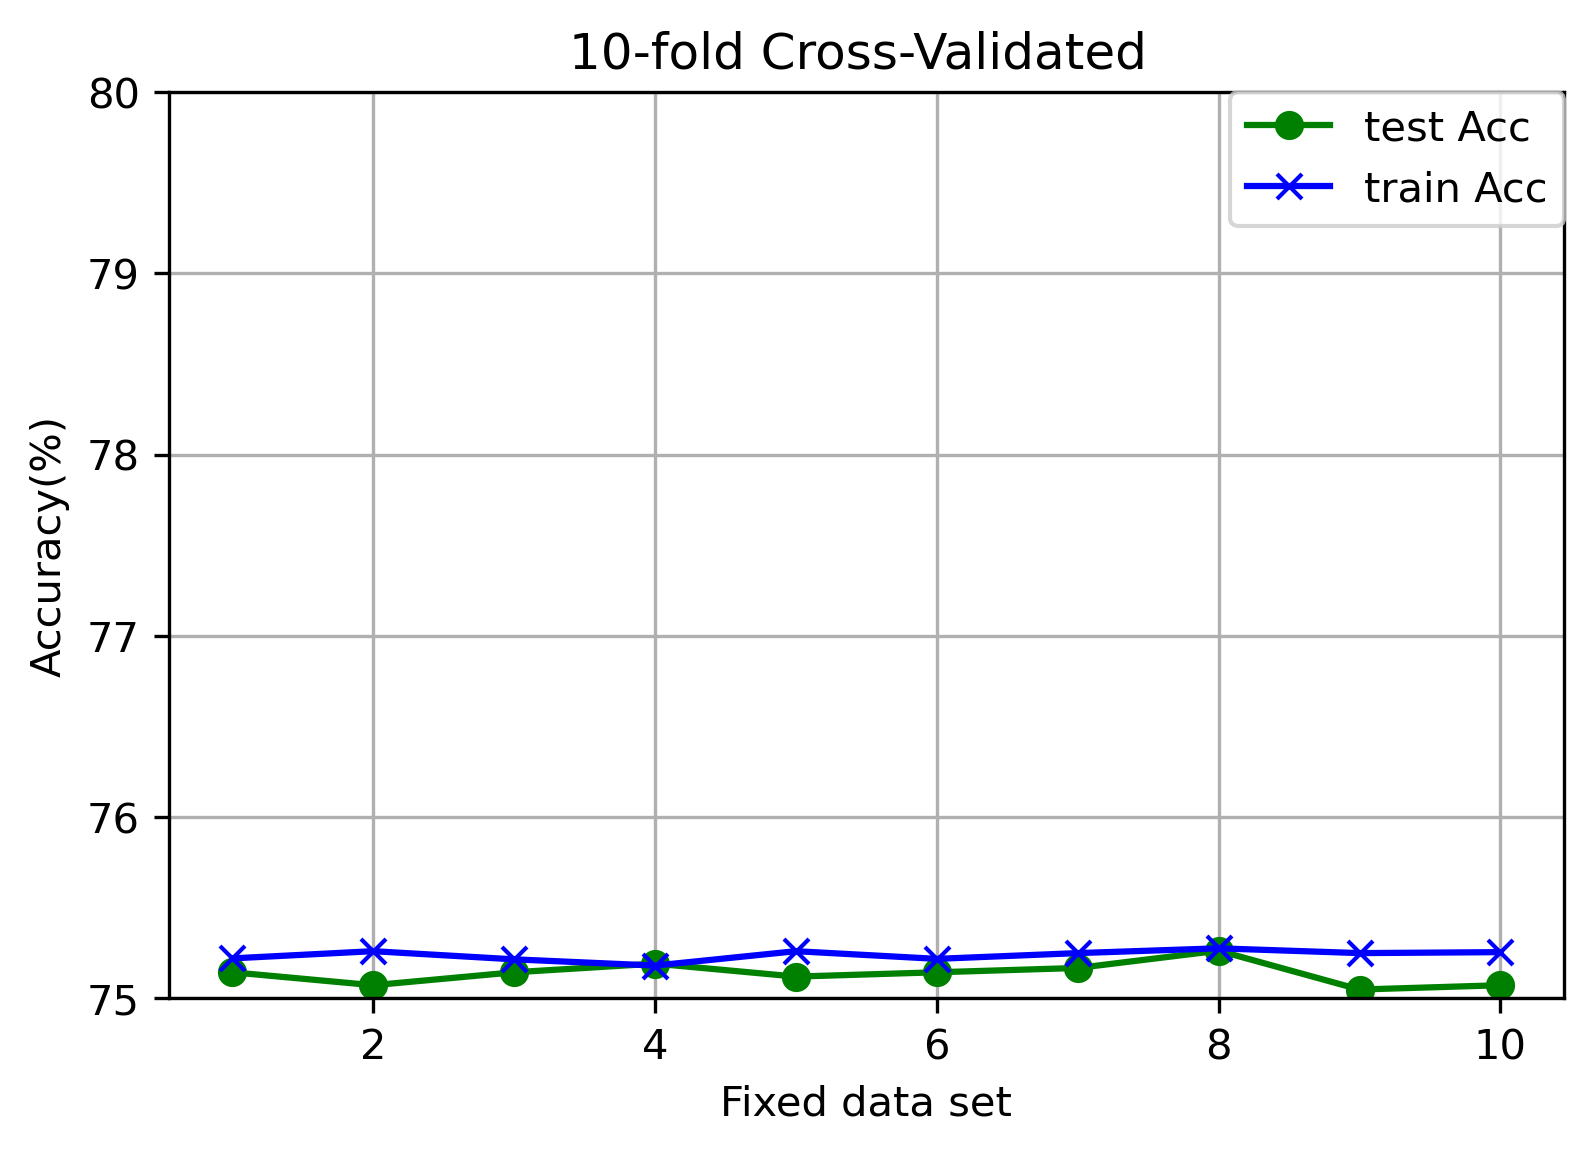

In [11]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(dpi=300)

ax.set_ylim([75,80])

plt.title("10-fold Cross-Validated ")
plt.xlabel('Fixed data set')
plt.ylabel('Accuracy(%)')

plt.plot(range(1,11),list(np.array(cv_acc_list)*100),'g-o',label="test Acc")
plt.plot(range(1,11),list(np.array(cv_acc_list_train)*100),'b-x',label="train Acc")

plt.grid(True)
plt.legend(bbox_to_anchor=(1.0, 1), loc=1, borderaxespad=0.)

plt.show()

#### evaluate

In [12]:
# best iter
s = 8
kernel = ShortestPath
### 1.Assign training & validation set
# (1).fix one set for validation
x_test = globals()[f'sub{s}'].Graph
y_test = globals()[f'sub{s}'].Label

# (2).nine set for training
train = pd.concat([eval(f'sub{n}') for n in range(1,11) if n != s],axis=0).reset_index(drop=True)
x_train = train.Graph
y_train = train.Label

### 2.10 iterations of training
# (1).Use the "shortest path kernel" to generate kernel matrices
gk1 = kernel(normalize=True)
K1_train = gk1.fit_transform(x_train)
K1_test = gk1.transform(x_test)

# (2).Using SVM classifier for classification
clf = SVC(kernel="precomputed")
clf.fit(K1_train, y_train)
y_pred = clf.predict(K1_test)
y_score = clf.fit(K1_train, y_train).decision_function(K1_test)

# (3).caculate classification accuracy
acc = accuracy_score(y_test, y_pred)

# (4).train predict 
y_pred_train = clf.predict(K1_train)
acc_train = accuracy_score(y_train, y_pred_train)

print(f"{s} iter Accuracy(train,test):", str(round(acc_train*100, 2)) + "%", str(round(acc*100, 2)) + "%")


8 iter Accuracy(train,test): 75.28% 75.26%


##### Prediction error

In [13]:
globals()[f'sub{s}']['Pre_Label'] = y_pred
globals()[f'sub{s}']

,Sent,Graph,Gene1,Gene2,Gene1_loc,Gene2_loc,Label,Pre_Label
0,The analysis concerned KL-VS polymorphism alon...,"[{0: {1: 0.3}, 1: {0: 0.3, 2: 0.3}, 2: {1: 0.3...",3383,7124,44,15,KEGG_Interaction,NON_KEGG_Interaction
1,"Of those studies, there were 21 studies for ke...","[{0: {2: 0.3}, 1: {2: 0.3}, 2: {0: 0.3, 1: 0.3...",6352,1234,24,15,KEGG_Interaction,NON_KEGG_Interaction
2,The association of kegg_Gene_595 G870A and keg...,"[{0: {1: 0.3}, 1: {0: 0.3, 4: 0.3, 11: 0.3, 19...",999,1499,28,39,KEGG_Interaction,NON_KEGG_Interaction
3,Patients with SHL had tumors with a higher pre...,"[{0: {2: 0.3, 3: 0.3}, 1: {2: 0.3}, 2: {0: 0.3...",7157,596,10,22,KEGG_Interaction,NON_KEGG_Interaction
4,Compared with macrophages from healthy subject...,"[{0: {2: 0.3}, 1: {2: 0.3}, 2: {0: 0.3, 1: 0.3...",3656,7189,19,21,KEGG_Interaction,NON_KEGG_Interaction
...,...,...,...,...,...,...,...,...
4195,"RESULTS: Expected and observed kegg_Gene_3123,...","[{0: {1: 0.3, 13: 0.3}, 1: {0: 0.3}, 2: {3: 0....",3119,3123,7,16,NON_KEGG_Interaction,NON_KEGG_Interaction
4196,Population-based study of changing breast canc...,"[{0: {1: 0.3}, 1: {0: 0.3, 3: 0.9, 22: 0.9}, 2...",675,672,9,20,NON_KEGG_Interaction,NON_KEGG_Interaction
4197,The ratios of observed to expected number of k...,"[{0: {1: 0.3}, 1: {0: 0.3, 6: 0.9, 16: 0.9}, 2...",675,672,10,52,NON_KEGG_Interaction,NON_KEGG_Interaction
4198,Patients were genotyped for the kegg_Gene_185 ...,"[{0: {2: 0.3}, 1: {2: 0.3}, 2: {0: 0.3, 1: 0.3...",1636,4846,16,21,NON_KEGG_Interaction,NON_KEGG_Interaction


In [14]:
# View predicted wrongly Labels
SDP_pre_err = globals()[f'sub{s}'].loc[globals()[f'sub{s}'].Label != globals()[f'sub{s}'].Pre_Label,['Sent','Gene1_loc','Gene2_loc','Label','Pre_Label']]

In [15]:
#save
%cd /home/tku_stat_dell/Desktop/DS_corpus/predict_error
SDP_pre_err.to_pickle('SDP_pre_err_3.pkl')

/home/tku_stat_dell/Desktop/DS_corpus/predict_error


In [26]:
# #load
# %cd /home/tku_stat_dell/Desktop/DS_corpus/predict_error
# SDP_pre_err = pd.read_pickle('SDP_pre_err.pkl')

/home/tku_stat_ibm4/Desktop/DS_corpus/predict_error


##### 1.confusion matrix

In [86]:
y_test = y_validation

[Text(0, 0.5, 'KEGG_Interaction'), Text(0, 1.5, 'NON_KEGG_Interaction')]

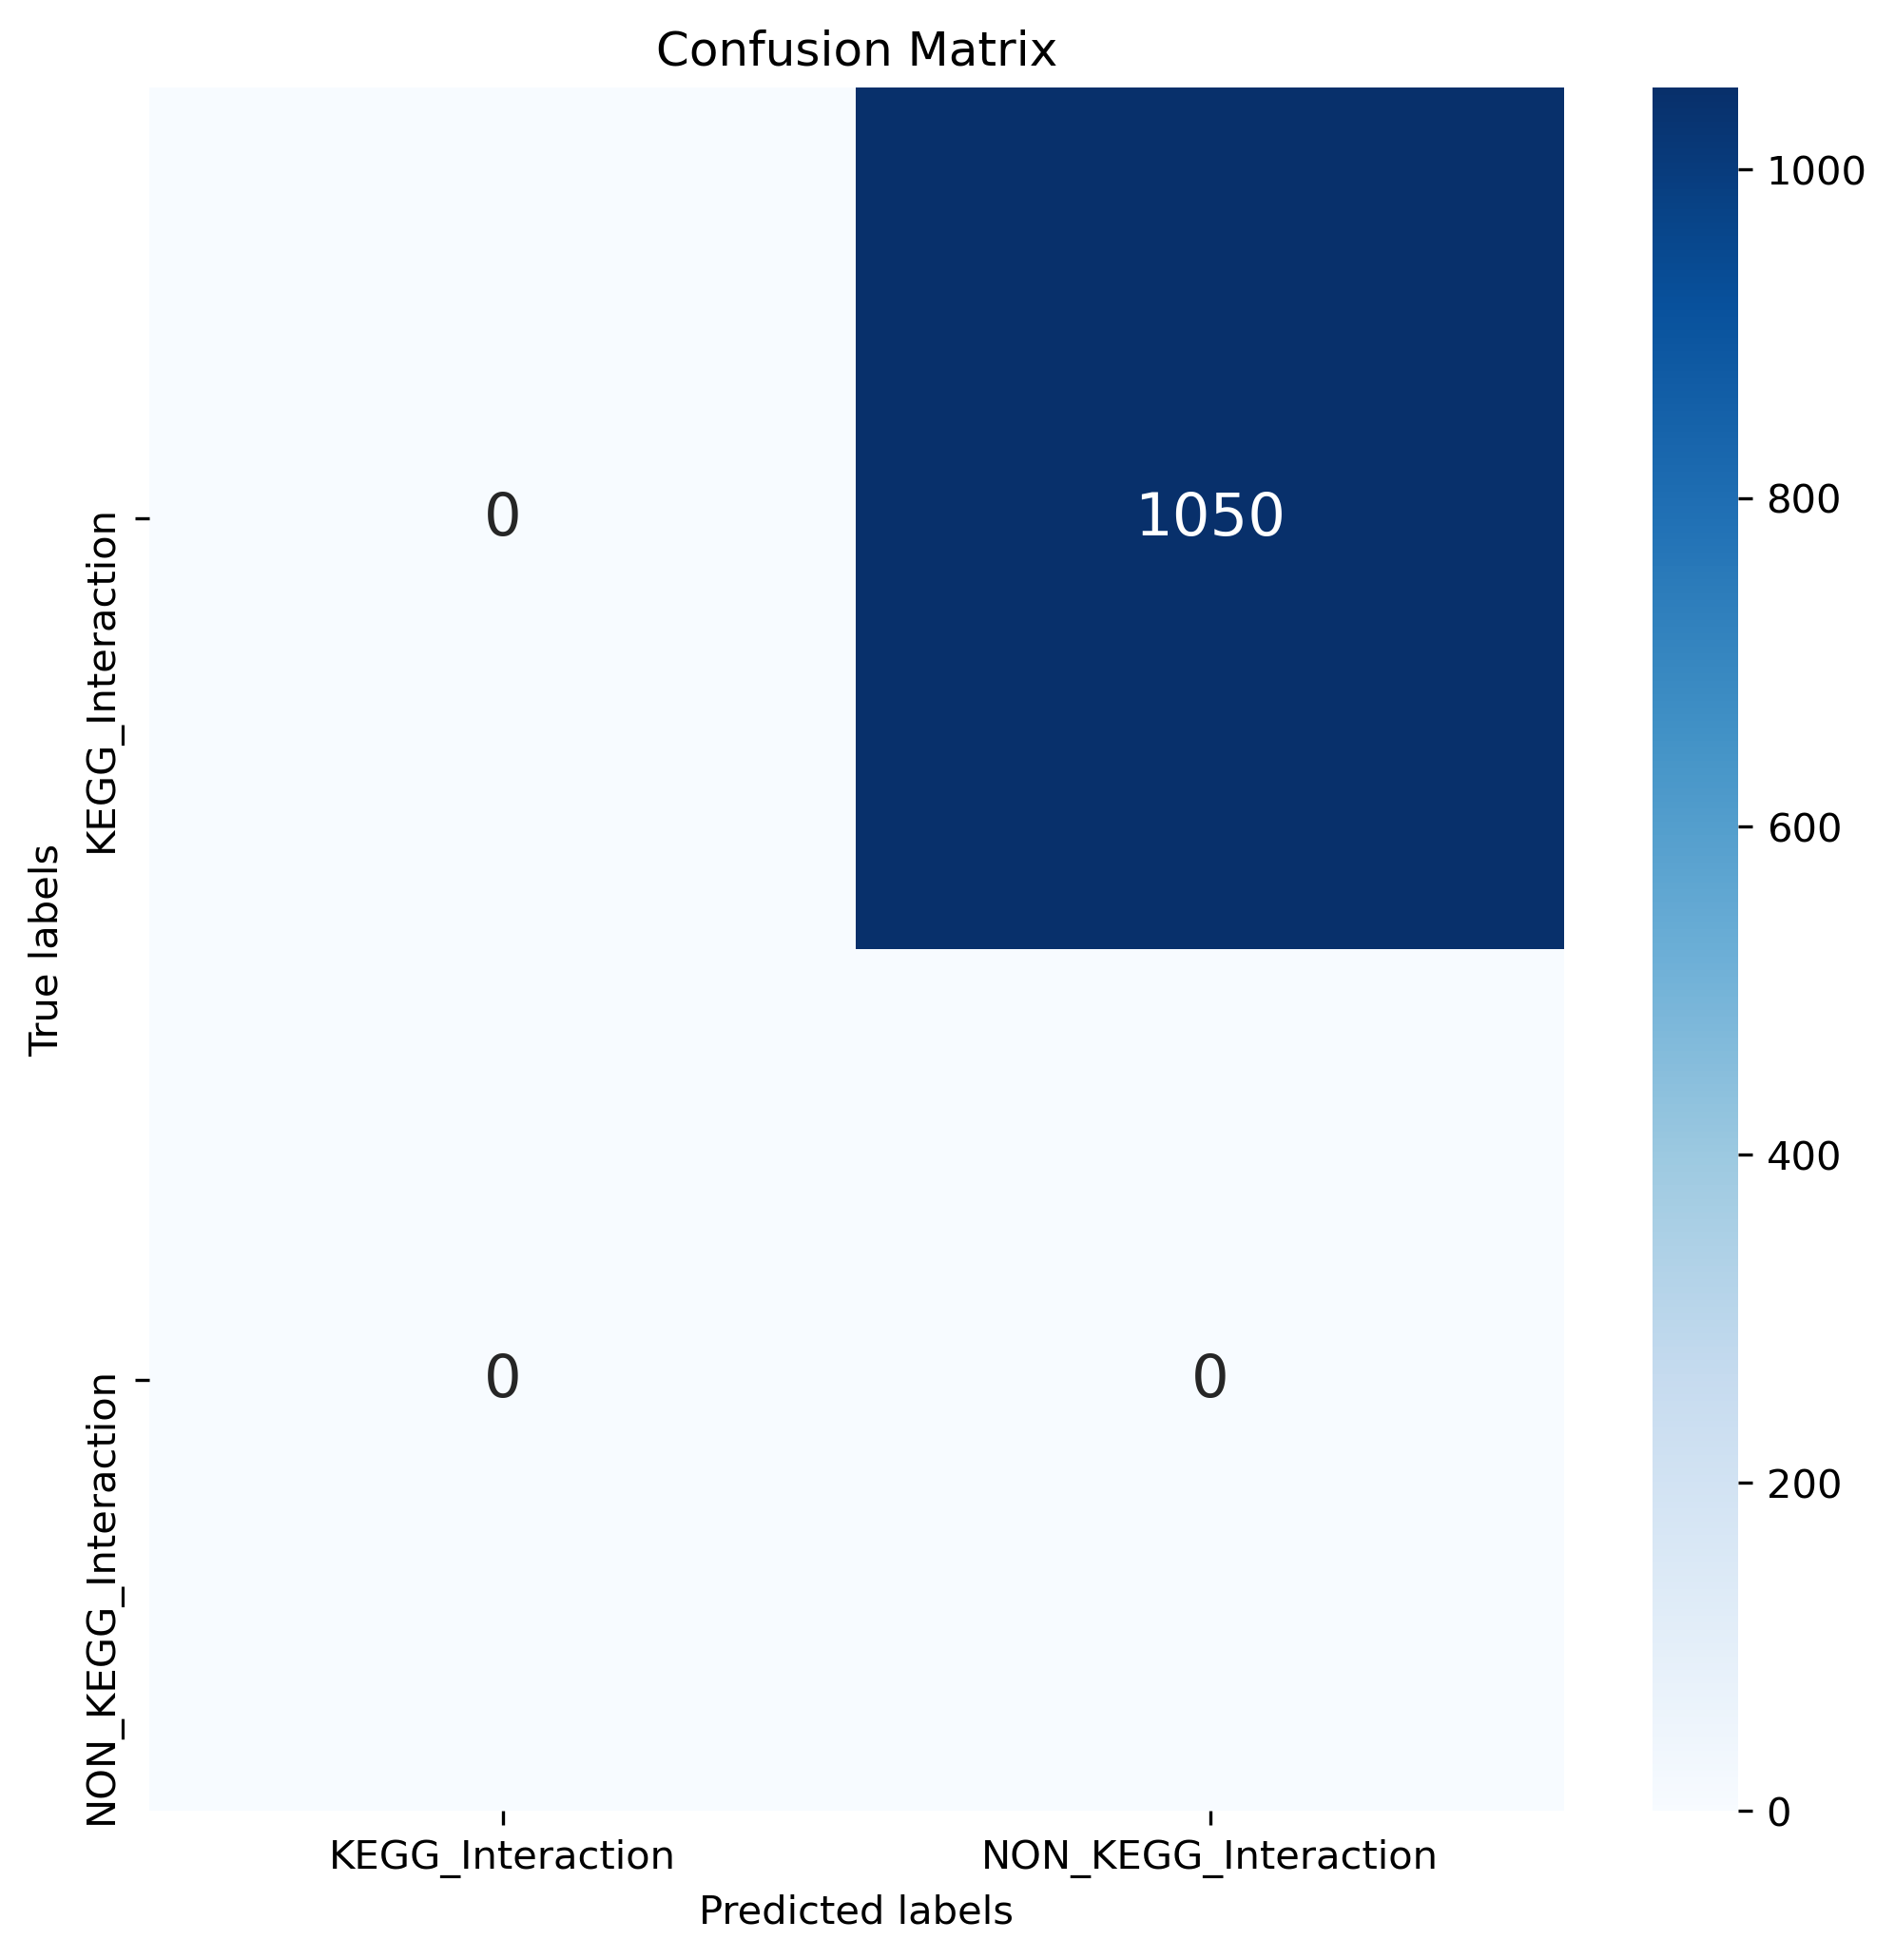

In [87]:
## 1.confusion matrix
cm = confusion_matrix(y_test,y_pred)

fig, ax = plt.subplots(figsize=(8,8),dpi=300)
sns.heatmap(cm,annot=True, annot_kws={"size": 15},cmap='Blues', fmt='g')
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(["KEGG_Interaction", "NON_KEGG_Interaction"]) 
ax.yaxis.set_ticklabels(["KEGG_Interaction", "NON_KEGG_Interaction"])

##### 2.precision, recall, f1-score

In [17]:
## 2.precision, recall, f1-score
#Official documents : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
#Interpret the results : https://www.libinx.com/2018/understanding-sklearn-classification-report/

print(classification_report(y_test, y_pred, ['KEGG_Interaction','NON_KEGG_Interaction']))

                      precision    recall  f1-score   support

    KEGG_Interaction       1.00      0.01      0.02      1050
NON_KEGG_Interaction       0.75      1.00      0.86      3150

            accuracy                           0.75      4200
           macro avg       0.88      0.51      0.44      4200
        weighted avg       0.81      0.75      0.65      4200



/home/tku_stat_dell/anaconda3/envs/tsai/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=['KEGG_Interaction', 'NON_KEGG_Interaction'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


##### 3.ROC-AUC curve

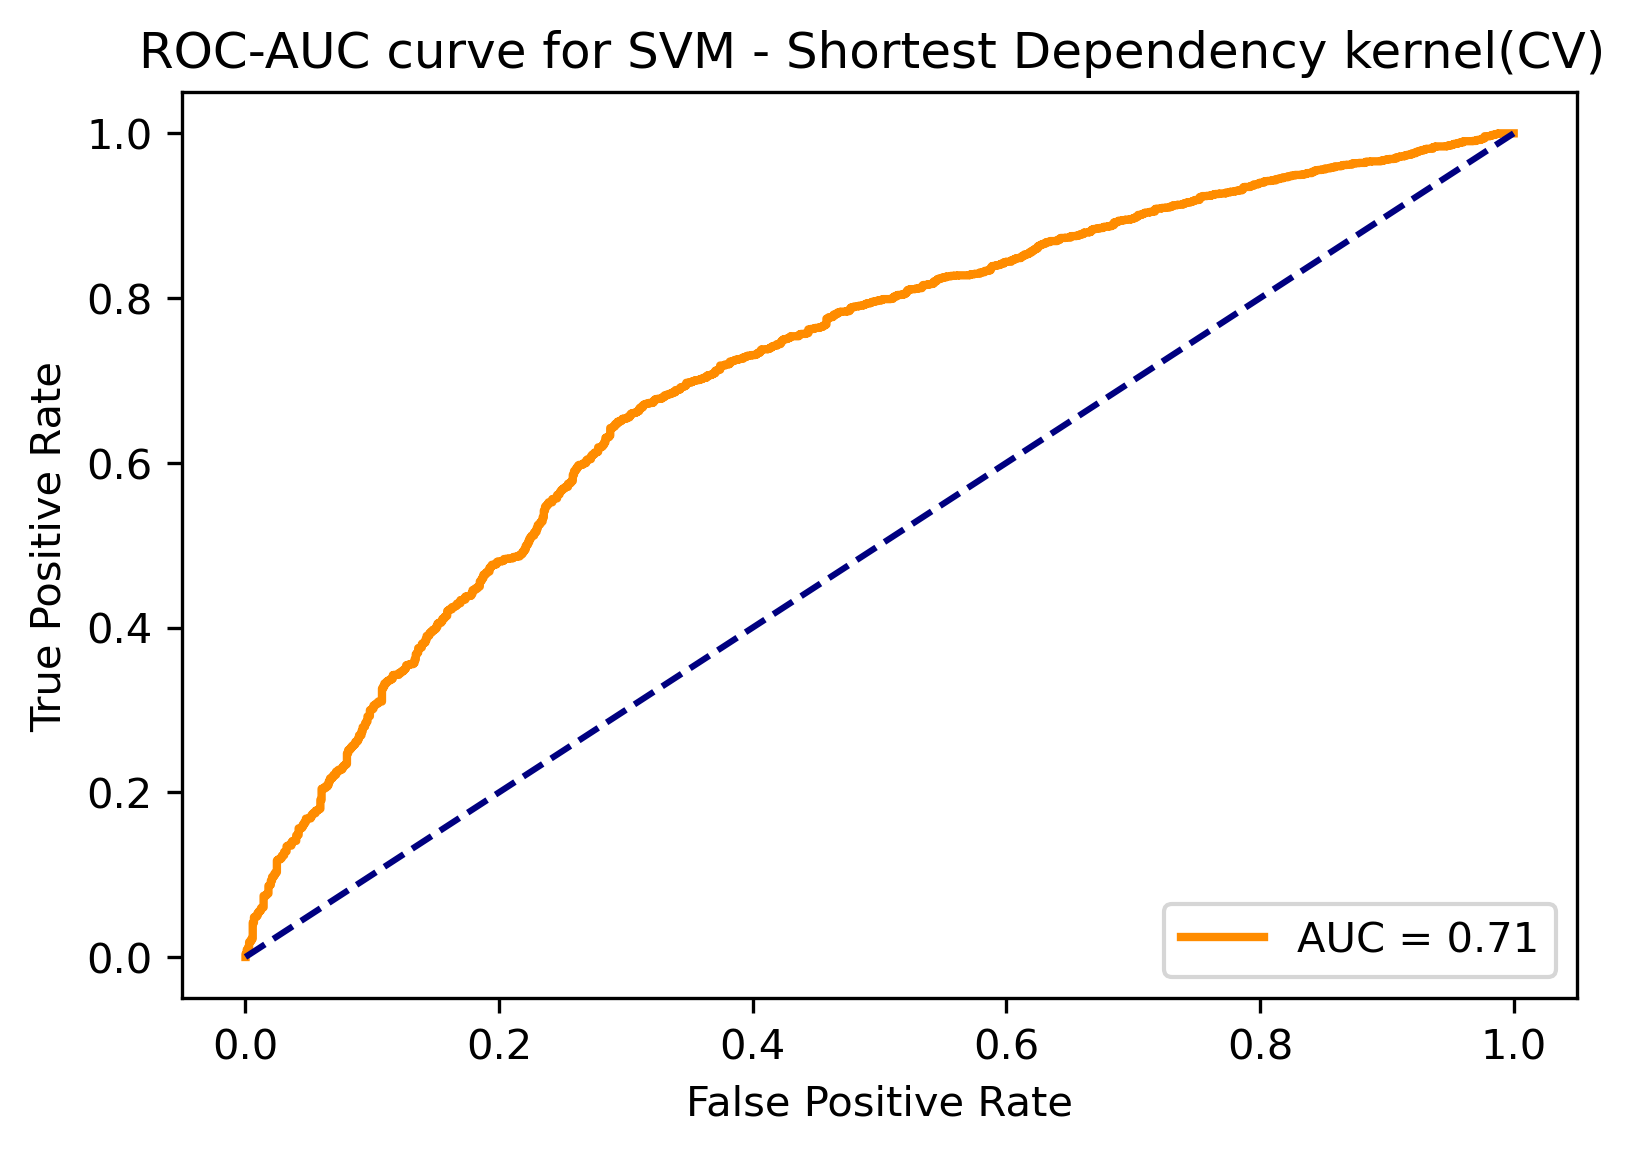

In [18]:
## 3.ROC-AUC curve
y_test_bool = np.asarray(list(map(int,[x=='NON_KEGG_Interaction' for x in y_test])))+1
plotROC_AUC(y_test_bool, y_score,'SVM - Shortest Dependency kernel(CV) ')

### WeisfeilerLehman kernel
https://ysig.github.io/GraKeL/0.1a8/generated/grakel.WeisfeilerLehman.html

#### classifier example

In [10]:
from grakel.kernels import WeisfeilerLehman

In [11]:
# kernel
kernel = WeisfeilerLehman
s=10

print('test:',len(TEST_all))
print('train:',len(TRAIN_all))


# (1).Test
x_validation = TEST_all.Graph
y_validation = TEST_all.Label

# (2).Training
x_train = TRAIN_all.Graph
y_train = TRAIN_all.Label

# (3).Use the "shortest path kernel" to generate kernel matrices
gk1 = kernel(normalize=True)
K1_train = gk1.fit_transform(x_train)
K1_test = gk1.transform(x_validation)

# (4).Using SVM classifier for classification
clf = SVC(kernel="precomputed")
clf.fit(K1_train, y_train)
y_pred = clf.predict(K1_test)
y_score = clf.fit(K1_train, y_train).decision_function(K1_test)

# (5).caculate classification accuracy
acc = accuracy_score(y_validation, y_pred)

# (6).train predict 
y_pred_train = clf.predict(K1_train)
acc_train = accuracy_score(y_train, y_pred_train)

print(f"{s} iter Accuracy(train,test):", str(round(acc_train*100, 2)) + "%", str(round(acc*100, 2)) + "%")



test: 1050
train: 40950
10 iter Accuracy(train,test): 82.21% 13.9%


In [14]:
# predict result
TEST_all['Pre_Label'] = y_pred

# save
%cd /home/tku_stat_dell/Desktop/DS_corpus/predict_result
TEST_all.to_pickle('WLK_result.pkl')

# load
%cd /home/tku_stat_dell/Desktop/DS_corpus/predict_result
WLK_result = pd.read_pickle('WLK_result.pkl')

/home/tku_stat_dell/Desktop/DS_corpus/predict_result
/home/tku_stat_dell/Desktop/DS_corpus/predict_result


In [20]:
# View predicted correct Labels
WL_pre_acc = WLK_result.loc[WLK_result.Label == WLK_result.Pre_Label,['Sent','Gene1_loc','Gene2_loc','Label','Pre_Label']]
WL_pre_acc

,Sent,Gene1_loc,Gene2_loc,Label,Pre_Label
12,"Since 1996, nine MSMD-causing genes, including...",13,17,KEGG_Interaction,KEGG_Interaction
13,Twenty-eight polymorphisms in eight genes of p...,9,39,KEGG_Interaction,KEGG_Interaction
18,The most widely studied group were genes encod...,49,40,KEGG_Interaction,KEGG_Interaction
19,METHODS: We genotyped a total of 48 potentiall...,24,32,KEGG_Interaction,KEGG_Interaction
20,Genetic polymorphisms for kegg_Gene_1543 ( keg...,8,20,KEGG_Interaction,KEGG_Interaction
...,...,...,...,...,...
1024,kegg_Gene_1956 and kegg_Gene_3845 mutation tes...,2,20,KEGG_Interaction,KEGG_Interaction
1026,Twenty-eight polymorphisms in eight genes of p...,19,35,KEGG_Interaction,KEGG_Interaction
1032,"The genotypes of kegg_Gene_1543, kegg_Gene_294...",7,3,KEGG_Interaction,KEGG_Interaction
1042,"Gene_1565, Gene_5444, kegg_Gene_2944, kegg_Gen...",4,14,KEGG_Interaction,KEGG_Interaction


In [19]:
WL_pre_index = list(WL_pre_acc.index)
print(WL_pre_index)

[12, 13, 18, 19, 20, 40, 43, 48, 54, 55, 58, 61, 83, 92, 97, 105, 114, 122, 148, 178, 186, 198, 202, 205, 222, 225, 228, 230, 231, 241, 263, 279, 282, 291, 296, 299, 301, 305, 307, 315, 322, 324, 338, 341, 352, 356, 359, 361, 362, 363, 365, 372, 380, 405, 410, 411, 415, 425, 427, 435, 442, 454, 462, 466, 471, 493, 500, 501, 527, 548, 555, 560, 571, 575, 577, 597, 598, 599, 606, 608, 616, 625, 626, 628, 638, 640, 652, 653, 654, 655, 656, 664, 669, 676, 681, 693, 703, 722, 724, 726, 737, 745, 746, 757, 764, 768, 785, 786, 787, 792, 802, 812, 814, 832, 834, 840, 843, 852, 857, 863, 881, 888, 892, 894, 895, 900, 908, 914, 920, 925, 936, 949, 952, 958, 959, 968, 974, 976, 986, 990, 1014, 1024, 1026, 1032, 1042, 1044]


#### 10 fold  cross-validation

In [9]:
cv_acc_list = []
cv_acc_list_train = []
for s in range(1,11):
    acc = k_fold_fast(s,WeisfeilerLehman)
    cv_acc_list_train.append(acc[0])
    cv_acc_list.append(acc[1])

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


1 iter Accuracy(train,test): 81.23% 77.71%


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


2 iter Accuracy(train,test): 81.3% 77.64%


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


3 iter Accuracy(train,test): 81.48% 77.26%


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


4 iter Accuracy(train,test): 81.22% 77.95%


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


5 iter Accuracy(train,test): 81.44% 76.74%


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


6 iter Accuracy(train,test): 81.24% 78.02%


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


7 iter Accuracy(train,test): 81.25% 78.19%


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


8 iter Accuracy(train,test): 81.39% 77.71%


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


9 iter Accuracy(train,test): 81.35% 77.52%


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


10 iter Accuracy(train,test): 81.22% 77.52%


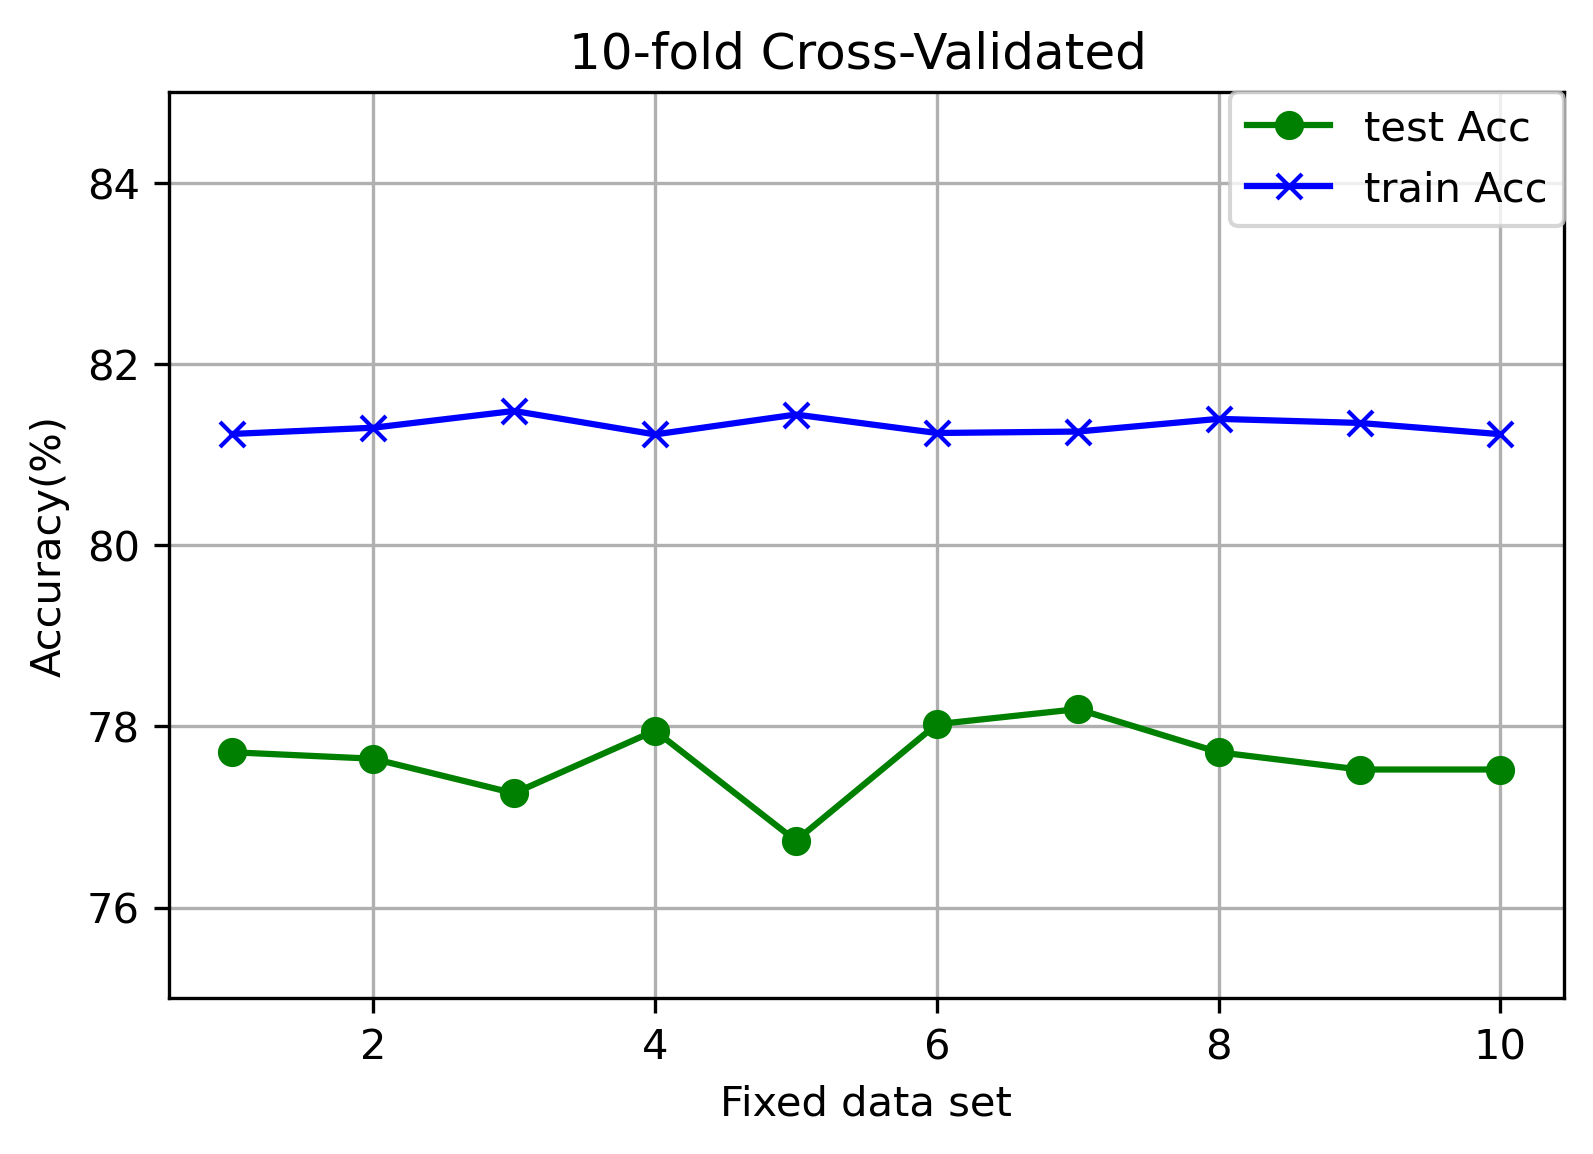

In [10]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(dpi=300)

ax.set_ylim([75,85])

plt.title("10-fold Cross-Validated ")
plt.xlabel('Fixed data set')
plt.ylabel('Accuracy(%)')

plt.plot(range(1,11),list(np.array(cv_acc_list)*100),'g-o',label="test Acc")
plt.plot(range(1,11),list(np.array(cv_acc_list_train)*100),'b-x',label="train Acc")

plt.grid(True)
plt.legend(bbox_to_anchor=(1.0, 1), loc=1, borderaxespad=0.)

plt.show()

#### evaluate

In [11]:
# best iter
s = 7
kernel = WeisfeilerLehman
### 1.Assign training & validation set
# (1).fix one set for validation
x_test = globals()[f'sub{s}'].Graph
y_test = globals()[f'sub{s}'].Label

# (2).nine set for training
train = pd.concat([eval(f'sub{n}') for n in range(1,11) if n != s],axis=0).reset_index(drop=True)
x_train = train.Graph
y_train = train.Label

### 2.10 iterations of training
# (1).Use the "shortest path kernel" to generate kernel matrices
gk1 = kernel(normalize=True)
K1_train = gk1.fit_transform(x_train)
K1_test = gk1.transform(x_test)

# (2).Using SVM classifier for classification
clf = SVC(kernel="precomputed")
clf.fit(K1_train, y_train)
y_pred = clf.predict(K1_test)
y_score = clf.fit(K1_train, y_train).decision_function(K1_test)

# (3).caculate classification accuracy
acc = accuracy_score(y_test, y_pred)

# (4).train predict 
y_pred_train = clf.predict(K1_train)
acc_train = accuracy_score(y_train, y_pred_train)

print(f"{s} iter Accuracy(train,test):", str(round(acc_train*100, 2)) + "%", str(round(acc*100, 2)) + "%")


7 iter Accuracy(train,test): 81.25% 78.19%


##### Prediction error

In [12]:
globals()[f'sub{s}']['Pre_Label'] = y_pred
globals()[f'sub{s}']

,Sent,Graph,Gene1,Gene2,Gene1_loc,Gene2_loc,Label,Pre_Label
0,Our objective was to measure the interactions ...,"[{0: {1: 0.3}, 1: {0: 0.3, 2: 0.3}, 2: {1: 0.3...",2944,1571,20,17,KEGG_Interaction,NON_KEGG_Interaction
1,"In conclusion, kegg_Gene_4790 gene rs28362491 ...","[{0: {1: 0.3}, 1: {0: 0.3, 9: 0.3}, 2: {9: 0.3...",4790,3569,3,35,KEGG_Interaction,NON_KEGG_Interaction
2,"We propose that kegg_Gene_7128 (rs6920220), ke...","[{0: {1: 0.3}, 1: {0: 0.3, 20: 0.3, 36: 0.3}, ...",7128,4790,3,14,KEGG_Interaction,NON_KEGG_Interaction
3,kegg_Gene_9817 mutations were spread over the ...,"[{0: {1: 0.9}, 1: {0: 0.9, 3: 0.9}, 2: {3: 0.3...",9817,4780,0,10,KEGG_Interaction,NON_KEGG_Interaction
4,RESULTS: We identified 15 significantly mutate...,"[{0: {3: 0.3}, 1: {3: 0.3}, 2: {3: 0.3}, 3: {0...",673,3845,31,11,KEGG_Interaction,NON_KEGG_Interaction
...,...,...,...,...,...,...,...,...
4195,We identified 12 novel nucleotide substitution...,"[{0: {1: 0.3}, 1: {0: 0.3, 6: 0.3, 56: 0.3}, 2...",3458,1493,21,48,NON_KEGG_Interaction,NON_KEGG_Interaction
4196,RESULTS: Seventeen SNPs distributed across 12 ...,"[{0: {1: 0.3, 45: 0.3}, 1: {0: 0.3}, 2: {3: 0....",2207,7096,15,37,NON_KEGG_Interaction,NON_KEGG_Interaction
4197,We also genotyped specific Gene_114327 variant...,"[{0: {2: 0.3}, 1: {2: 0.3}, 2: {0: 0.3, 1: 0.3...",114327,50715,4,31,NON_KEGG_Interaction,NON_KEGG_Interaction
4198,Both transverse aortic constriction and exerci...,"[{0: {3: 0.3}, 1: {3: 0.3}, 2: {3: 0.3}, 3: {0...",382056,226641,10,24,NON_KEGG_Interaction,NON_KEGG_Interaction


In [13]:
# View predicted wrongly Labels
WL_pre_err = globals()[f'sub{s}'].loc[globals()[f'sub{s}'].Label != globals()[f'sub{s}'].Pre_Label,['Sent','Gene1_loc','Gene2_loc','Label','Pre_Label']]

In [14]:
#save
%cd /home/tku_stat_dell/Desktop/DS_corpus/predict_error
WL_pre_err.to_pickle('WL_pre_err_3.pkl')

/home/tku_stat_dell/Desktop/DS_corpus/predict_error


In [ ]:
# #load
# %cd /home/tku_stat_dell/Desktop/DS_corpus/predict_error
# WL_pre_err = pd.read_pickle('WL_pre_err_3.pkl')

##### 1.confusion matrix

In [82]:
y_test = y_validation

[Text(0, 0.5, 'KEGG_Interaction'), Text(0, 1.5, 'NON_KEGG_Interaction')]

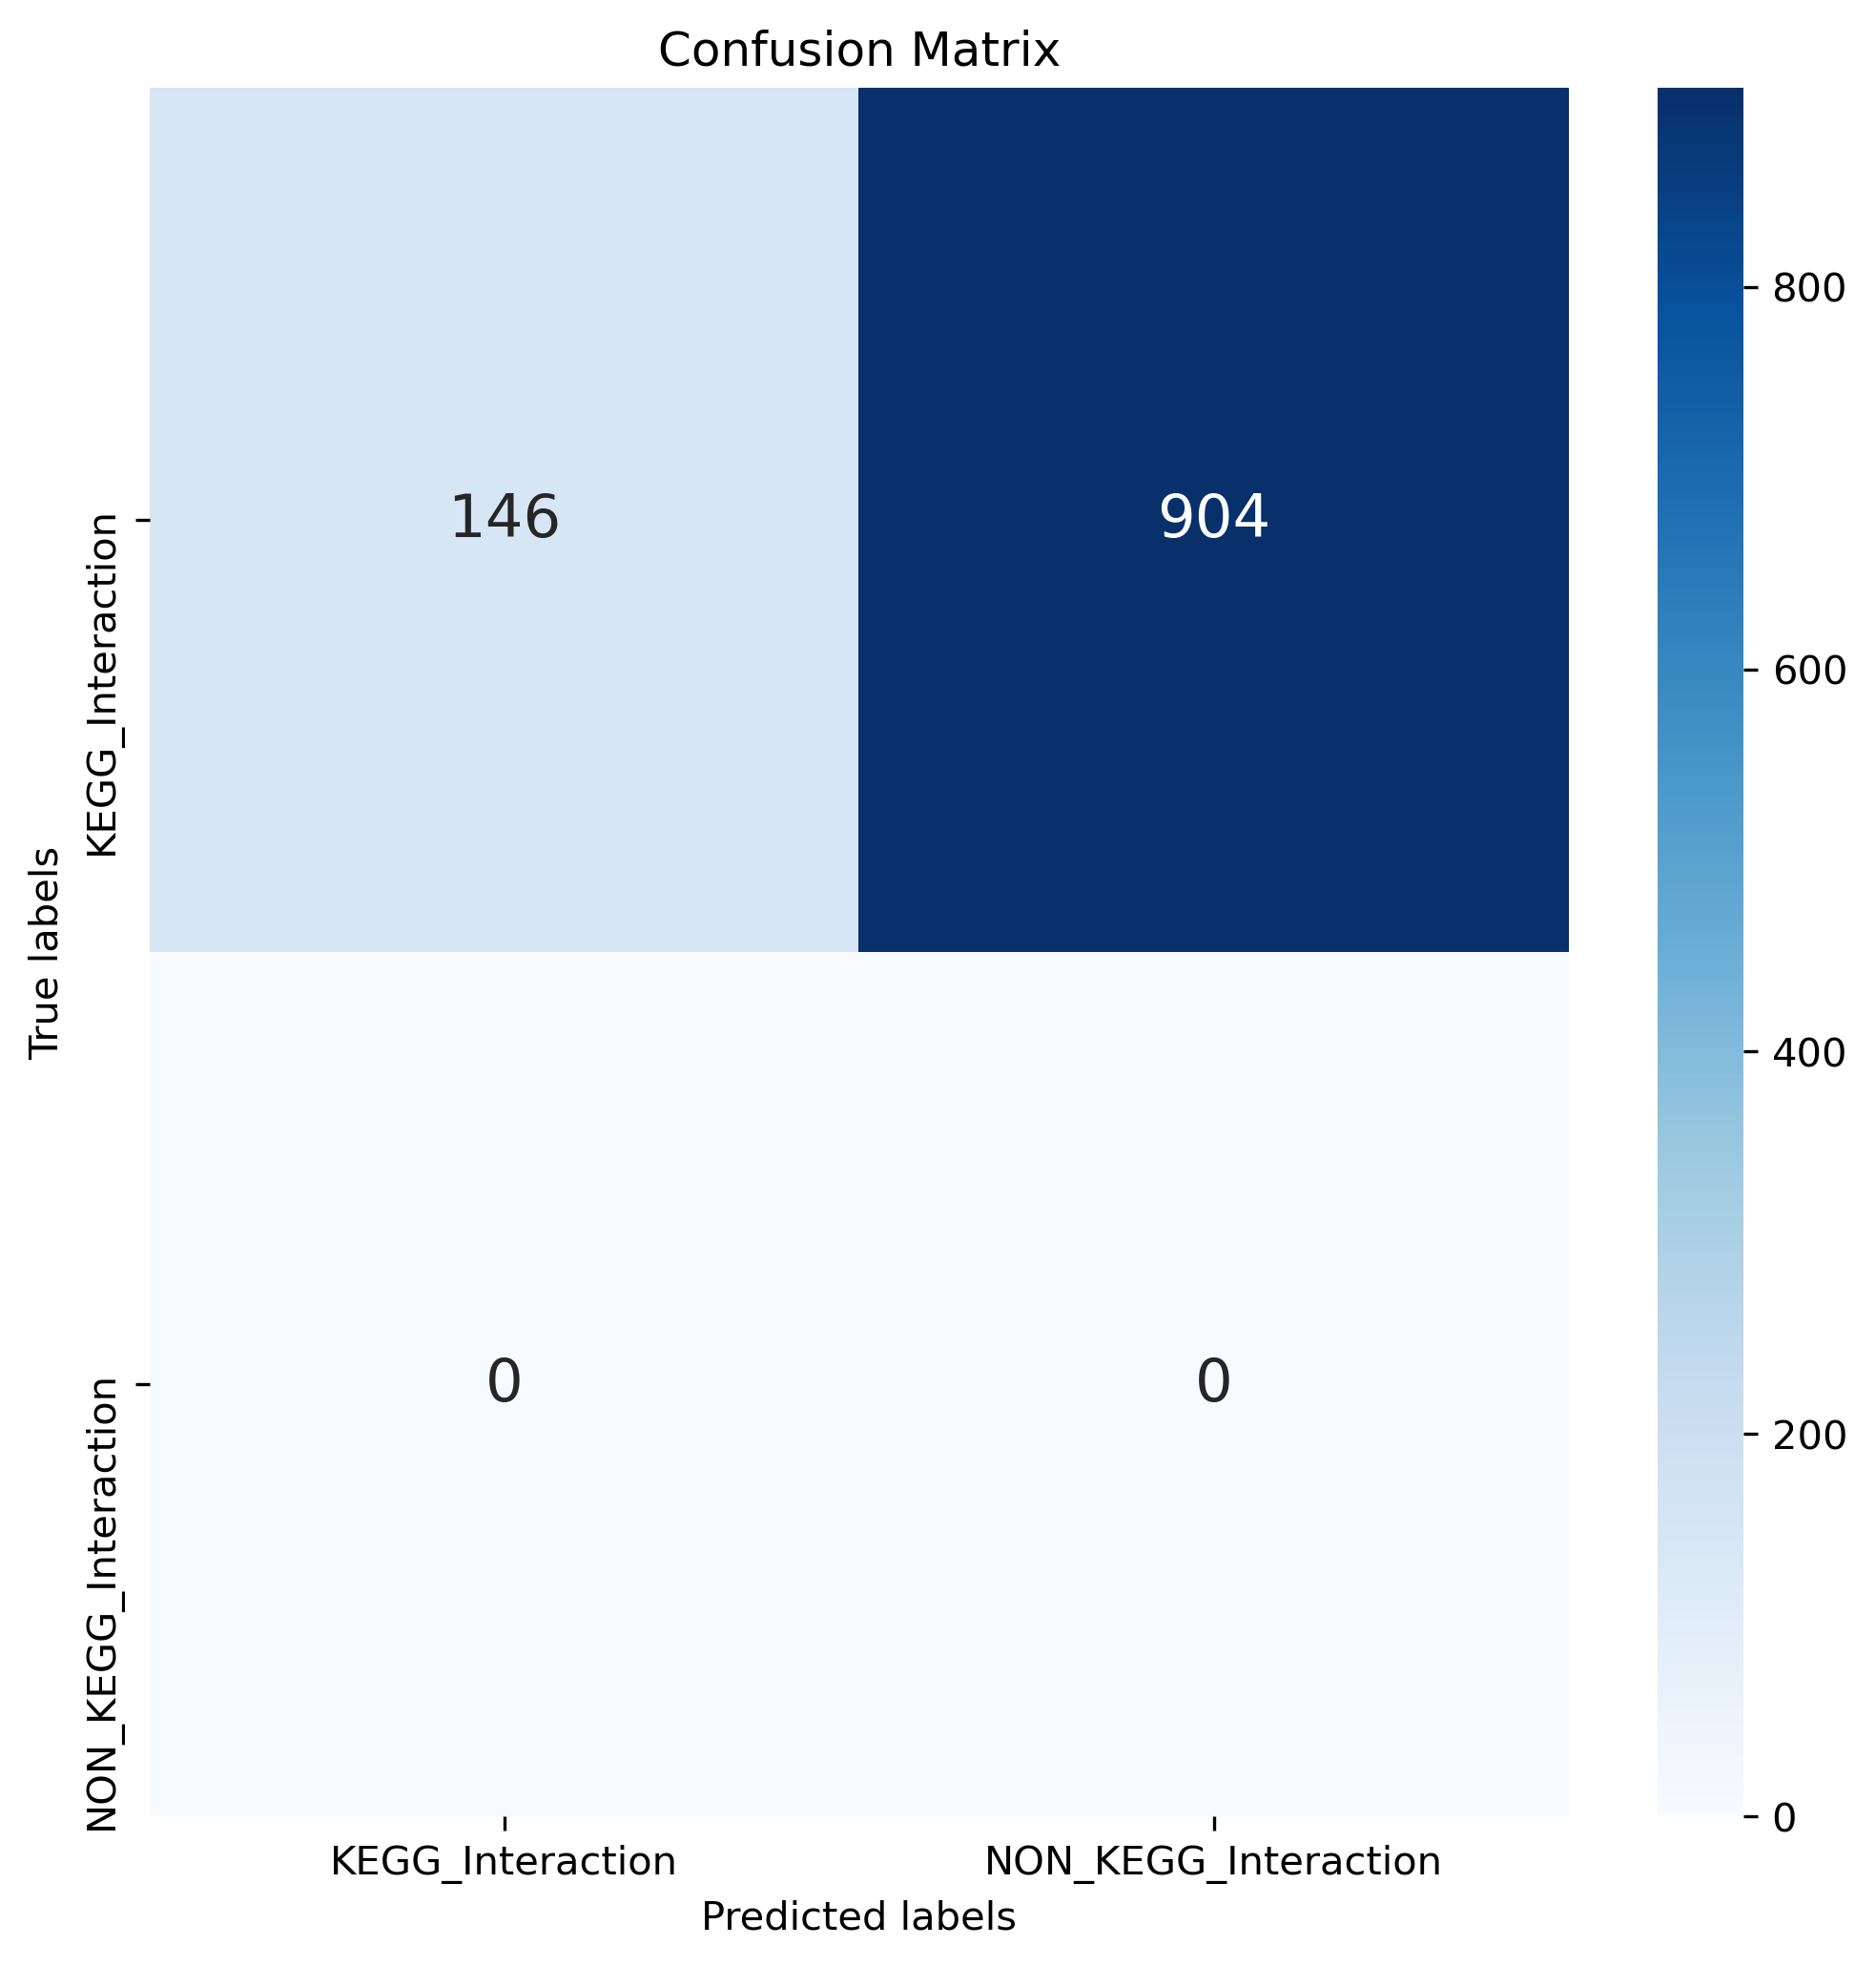

In [83]:
## 1.confusion matrix
cm = confusion_matrix(y_test,y_pred)

fig, ax = plt.subplots(figsize=(8,8),dpi=300)
sns.heatmap(cm,annot=True, annot_kws={"size": 15},cmap='Blues', fmt='g')
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(["KEGG_Interaction", "NON_KEGG_Interaction"]) 
ax.yaxis.set_ticklabels(["KEGG_Interaction", "NON_KEGG_Interaction"])

##### 2.precision, recall, f1-score

In [16]:
## 2.precision, recall, f1-score
#Official documents : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
#Interpret the results : https://www.libinx.com/2018/understanding-sklearn-classification-report/

print(classification_report(y_test, y_pred, ['KEGG_Interaction','NON_KEGG_Interaction']))

                      precision    recall  f1-score   support

    KEGG_Interaction       0.77      0.18      0.29      1050
NON_KEGG_Interaction       0.78      0.98      0.87      3150

            accuracy                           0.78      4200
           macro avg       0.78      0.58      0.58      4200
        weighted avg       0.78      0.78      0.73      4200



/home/tku_stat_dell/anaconda3/envs/tsai/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=['KEGG_Interaction', 'NON_KEGG_Interaction'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


##### 3.ROC-AUC curve

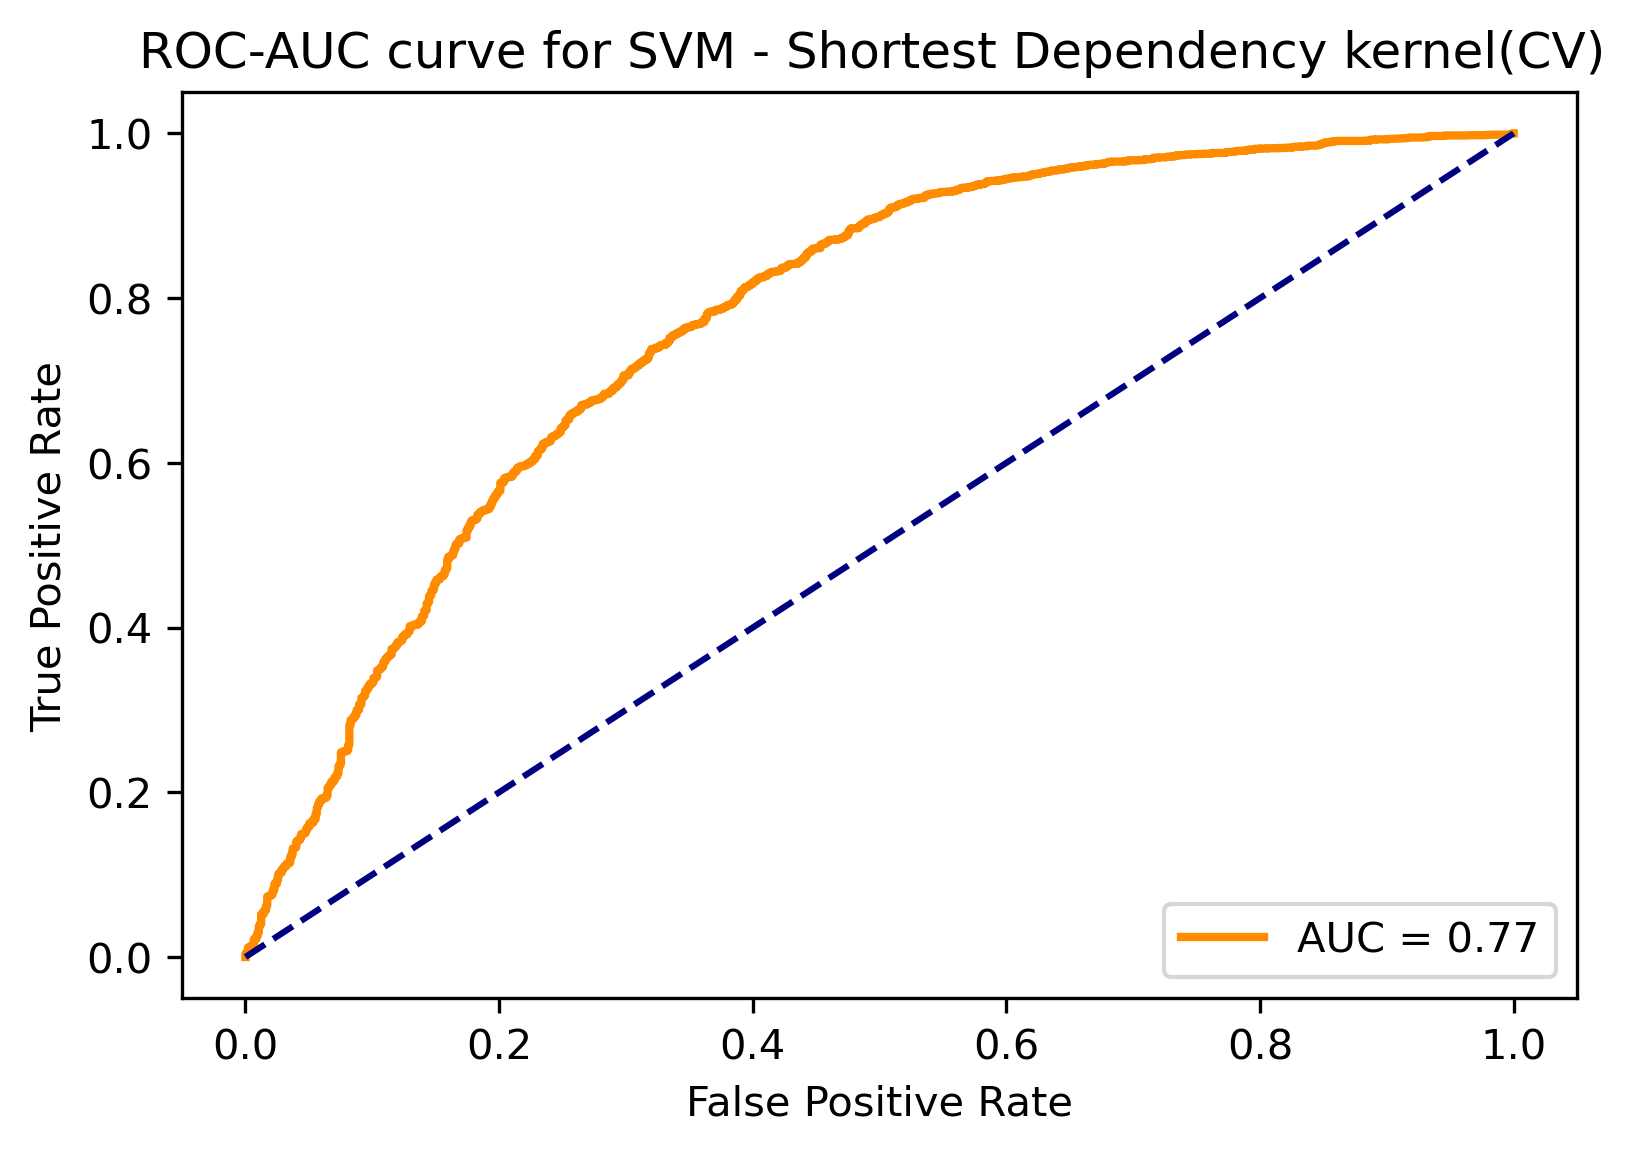

In [20]:
## 3.ROC-AUC curve
y_test_bool = np.asarray(list(map(int,[x=='NON_KEGG_Interaction' for x in y_test])))+1
plotROC_AUC(y_test_bool, y_score)

### NeighborhoodHash kernel
https://ysig.github.io/GraKeL/0.1a8/generated/grakel.NeighborhoodHash.html

#### classifier example

In [21]:
from grakel.kernels import NeighborhoodHash

In [22]:
# kernel
kernel = NeighborhoodHash
s=10

print('test:',len(TEST_all))
print('train:',len(TRAIN_all))


# (1).Test
x_validation = TEST_all.Graph
y_validation = TEST_all.Label

# (2).Training
x_train = TRAIN_all.Graph
y_train = TRAIN_all.Label

# (3).Use the "shortest path kernel" to generate kernel matrices
gk1 = kernel(normalize=True)
K1_train = gk1.fit_transform(x_train)
K1_test = gk1.transform(x_validation)

# (4).Using SVM classifier for classification
clf = SVC(kernel="precomputed")
clf.fit(K1_train, y_train)
y_pred = clf.predict(K1_test)
y_score = clf.fit(K1_train, y_train).decision_function(K1_test)

# (5).caculate classification accuracy
acc = accuracy_score(y_validation, y_pred)

# (6).train predict 
y_pred_train = clf.predict(K1_train)
acc_train = accuracy_score(y_train, y_pred_train)

print(f"{s} iter Accuracy(train,test):", str(round(acc_train*100, 2)) + "%", str(round(acc*100, 2)) + "%")



test: 1050
train: 40950
10 iter Accuracy(train,test): 83.64% 16.38%


In [23]:
# predict result
TEST_all['Pre_Label'] = y_pred

# save
%cd /home/tku_stat_dell/Desktop/DS_corpus/predict_result
TEST_all.to_pickle('NHK_result.pkl')

# load
%cd /home/tku_stat_dell/Desktop/DS_corpus/predict_result
NHK_result = pd.read_pickle('NHK_result.pkl')

/home/tku_stat_dell/Desktop/DS_corpus/predict_result
/home/tku_stat_dell/Desktop/DS_corpus/predict_result


In [24]:
# View predicted correct Labels
NH_pre_acc = NHK_result.loc[NHK_result.Label == NHK_result.Pre_Label,['Sent','Gene1_loc','Gene2_loc','Label','Pre_Label']]
NH_pre_acc

,Sent,Gene1_loc,Gene2_loc,Label,Pre_Label
12,"Since 1996, nine MSMD-causing genes, including...",13,17,KEGG_Interaction,KEGG_Interaction
13,Twenty-eight polymorphisms in eight genes of p...,9,39,KEGG_Interaction,KEGG_Interaction
18,The most widely studied group were genes encod...,49,40,KEGG_Interaction,KEGG_Interaction
19,METHODS: We genotyped a total of 48 potentiall...,24,32,KEGG_Interaction,KEGG_Interaction
20,Genetic polymorphisms for kegg_Gene_1543 ( keg...,8,20,KEGG_Interaction,KEGG_Interaction
...,...,...,...,...,...
1024,kegg_Gene_1956 and kegg_Gene_3845 mutation tes...,2,20,KEGG_Interaction,KEGG_Interaction
1026,Twenty-eight polymorphisms in eight genes of p...,19,35,KEGG_Interaction,KEGG_Interaction
1035,"Rare inactivating mutations in kegg_Gene_672, ...",8,10,KEGG_Interaction,KEGG_Interaction
1042,"Gene_1565, Gene_5444, kegg_Gene_2944, kegg_Gen...",4,14,KEGG_Interaction,KEGG_Interaction


In [25]:
NH_pre_index = list(NH_pre_acc.index)
print(NH_pre_index)

[12, 13, 18, 19, 20, 29, 40, 43, 45, 48, 54, 55, 58, 61, 81, 83, 92, 97, 114, 122, 126, 147, 148, 167, 178, 184, 186, 195, 198, 202, 222, 225, 230, 231, 241, 263, 279, 282, 285, 291, 296, 298, 299, 301, 305, 307, 313, 315, 316, 322, 338, 343, 344, 352, 356, 361, 362, 363, 365, 372, 373, 380, 403, 404, 405, 410, 411, 412, 415, 425, 427, 442, 454, 466, 471, 482, 492, 493, 500, 501, 523, 527, 543, 555, 560, 571, 575, 577, 586, 592, 597, 598, 599, 606, 608, 616, 623, 625, 626, 628, 638, 640, 641, 652, 653, 654, 655, 656, 664, 665, 669, 676, 678, 681, 693, 703, 722, 724, 726, 737, 745, 746, 757, 764, 767, 768, 785, 786, 792, 802, 812, 814, 818, 832, 834, 840, 843, 845, 852, 857, 858, 865, 881, 888, 892, 894, 895, 900, 908, 916, 920, 925, 936, 949, 952, 958, 959, 962, 968, 970, 974, 976, 986, 990, 998, 1013, 1014, 1024, 1026, 1035, 1042, 1044]


In [26]:
### interaction
inter_index = set(WL_pre_index) & set(NH_pre_index)
inter_index

{12,
 13,
 18,
 19,
 20,
 40,
 43,
 48,
 54,
 55,
 58,
 61,
 83,
 92,
 97,
 114,
 122,
 148,
 178,
 186,
 198,
 202,
 222,
 225,
 230,
 231,
 241,
 263,
 279,
 282,
 291,
 296,
 299,
 301,
 305,
 307,
 315,
 322,
 338,
 352,
 356,
 361,
 362,
 363,
 365,
 372,
 380,
 405,
 410,
 411,
 415,
 425,
 427,
 442,
 454,
 466,
 471,
 493,
 500,
 501,
 527,
 555,
 560,
 571,
 575,
 577,
 597,
 598,
 599,
 606,
 608,
 616,
 625,
 626,
 628,
 638,
 640,
 652,
 653,
 654,
 655,
 656,
 664,
 669,
 676,
 681,
 693,
 703,
 722,
 724,
 726,
 737,
 745,
 746,
 757,
 764,
 768,
 785,
 786,
 792,
 802,
 812,
 814,
 832,
 834,
 840,
 843,
 852,
 857,
 881,
 888,
 892,
 894,
 895,
 900,
 908,
 920,
 925,
 936,
 949,
 952,
 958,
 959,
 968,
 974,
 976,
 986,
 990,
 1014,
 1024,
 1026,
 1042,
 1044}

In [27]:
inter_DF = NHK_result.loc[inter_index,['Sent','Gene1_loc','Gene2_loc','Label','Pre_Label']]
inter_DF

,Sent,Gene1_loc,Gene2_loc,Label,Pre_Label
1024,kegg_Gene_1956 and kegg_Gene_3845 mutation tes...,2,20,KEGG_Interaction,KEGG_Interaction
1026,Twenty-eight polymorphisms in eight genes of p...,19,35,KEGG_Interaction,KEGG_Interaction
12,"Since 1996, nine MSMD-causing genes, including...",13,17,KEGG_Interaction,KEGG_Interaction
13,Twenty-eight polymorphisms in eight genes of p...,9,39,KEGG_Interaction,KEGG_Interaction
527,"Polymorphisms of kegg_Gene_1543, kegg_Gene_157...",2,6,KEGG_Interaction,KEGG_Interaction
...,...,...,...,...,...
990,Genotyping of a panel of eight selected single...,25,19,KEGG_Interaction,KEGG_Interaction
493,The role of kegg_Gene_2308 was examined by RNA...,32,3,KEGG_Interaction,KEGG_Interaction
500,We utilized data from 2 population-based case-...,61,68,KEGG_Interaction,KEGG_Interaction
501,In this paper the potential role of polymorphi...,42,36,KEGG_Interaction,KEGG_Interaction


In [48]:
for i in inter_DF.index:
    aa = inter_DF.loc[i,'Sent']
    print(aa,'\n')

kegg_Gene_1956 and kegg_Gene_3845 mutation testing was evaluated using real time polymerase chain reaction (RT-PCR cobas( )), kegg_Gene_673 and kegg_Gene_4893 mutations using multiplex PCR and capillary electrophoresis-single strand conformation analysis, and kegg_Gene_238 and MET aberrations with fluorescent in situ hybridization. 

Twenty-eight polymorphisms in eight genes of phase I (kegg_Gene_1543, kegg_Gene_1544, kegg_Gene_1545, kegg_Gene_1559, kegg_Gene_1557, kegg_Gene_1576, Gene_1577, Gene_1551) and nine genes of phase II enzymes (Gene_1312, kegg_Gene_2944, kegg_Gene_2947, kegg_Gene_2950, kegg_Gene_2952, Gene_6817, kegg_Gene_54658, kegg_Gene_54578, kegg_Gene_7364) were genotyped. 

Since 1996, nine MSMD-causing genes, including seven autosomal (kegg_Gene_3459, kegg_Gene_3460, kegg_Gene_6772, kegg_Gene_3593, kegg_Gene_3594, kegg_Gene_9636, and kegg_Gene_3394) and two X-linked (kegg_Gene_8517, and kegg_Gene_1536) genes have been discovered. 

Twenty-eight polymorphisms in eight ge

In [51]:
# only WLK
only_WLK_index = set(WL_pre_index) - set(inter_index)
WLK_DF = WLK_result.loc[only_WLK_index,:]


%cd /home/tku_stat_dell/Desktop/DS_corpus/predict_result
# save1
WLK_DF.to_csv(r'WLK_DF.csv', index=False)


WLK_DF

/home/tku_stat_dell/Desktop/DS_corpus/predict_result


,Sent,Graph,Gene1,Gene2,Gene1_loc,Gene2_loc,Label,Pre_Label
228,Sixteen single nucleotide polymorphisms (SNPs)...,"[{0: {3: 0.3}, 1: {3: 0.3}, 2: {3: 0.3}, 3: {0...",3480,3479,12,8,KEGG_Interaction,KEGG_Interaction
548,"Also, the levels of the individual DNA adducts...","[{0: {13: 0.3}, 1: {13: 0.3}, 2: {3: 0.3}, 3: ...",2944,1543,20,27,KEGG_Interaction,KEGG_Interaction
324,"kegg_Gene_2944, kegg_Gene_2952, kegg_Gene_2950...","[{0: {1: 0.3, 2: 0.9, 5: 0.3, 7: 0.3, 11: 0.3,...",2950,1543,4,13,KEGG_Interaction,KEGG_Interaction
359,"Eight up-regulated genes (SOCE, kegg_Gene_4318...","[{0: {2: 0.3}, 1: {2: 0.3}, 2: {0: 0.3, 1: 0.3...",2353,7124,18,16,KEGG_Interaction,KEGG_Interaction
1032,"The genotypes of kegg_Gene_1543, kegg_Gene_294...","[{0: {1: 0.3}, 1: {0: 0.3, 3: 0.3, 18: 0.3, 20...",2952,1543,7,3,KEGG_Interaction,KEGG_Interaction
105,"However, no significant difference was observe...","[{0: {6: 0.3}, 1: {6: 0.3}, 2: {4: 0.3}, 3: {4...",2950,1543,22,14,KEGG_Interaction,KEGG_Interaction
205,"Here, we investigated the association of kegg_...","[{0: {3: 0.3}, 1: {3: 0.3}, 2: {3: 0.3}, 3: {0...",1545,2950,10,13,KEGG_Interaction,KEGG_Interaction
462,"However, plasma membrane-proximal elements in ...","[{0: {13: 0.3}, 1: {13: 0.3}, 2: {4: 0.3}, 3: ...",4790,7189,48,22,KEGG_Interaction,KEGG_Interaction
914,kegg_Gene_5290 and MAPK mutations (kegg_Gene_3...,"[{0: {1: 0.3, 3: 0.9, 13: 0.3}, 1: {0: 0.3}, 2...",4893,5290,7,0,KEGG_Interaction,KEGG_Interaction
787,We genotyped 7 potentially functional polymorp...,"[{0: {1: 0.3}, 1: {0: 0.3, 5: 0.3, 16: 0.3, 20...",843,841,15,11,KEGG_Interaction,KEGG_Interaction


In [52]:
for i in WLK_DF.index:
    aa = WLK_DF.loc[i,'Sent']
    print(aa,'\n')

Sixteen single nucleotide polymorphisms (SNPs) in kegg_Gene_3479, kegg_Gene_3481, kegg_Gene_3480 and kegg_Gene_3481R have been genotyped by employing SNaPshot assays. 

Also, the levels of the individual DNA adducts were to some extent modified by genetic polymorphisms in kegg_Gene_1543, kegg_Gene_2944, kegg_Gene_2950 and kegg_Gene_1728 and by kegg_Gene_1543 inducibility. 

kegg_Gene_2944, kegg_Gene_2952, kegg_Gene_2950, Gene_7515 codons 194 and 399, and kegg_Gene_1543 codon 462 were examined by meta-analyses, and significant relations were found between the kegg_Gene_2944-null genotype and an increased risk for HNC. 

Eight up-regulated genes (SOCE, kegg_Gene_4318, kegg_Gene_3576, JUN, kegg_Gene_3553, kegg_Gene_4792, kegg_Gene_7124 and kegg_Gene_2353) have been examined with four interactions among different pathways. 

The genotypes of kegg_Gene_1543, kegg_Gene_2944, kegg_Gene_2952, kegg_Gene_2950, kegg_Gene_1571, kegg_Gene_1728, Gene_10 and Gene_13849 genes were determined by PCR-ba

In [53]:
# only NHK
only_NHK_index = set(NH_pre_index) - set(inter_index)
NHK_DF = NHK_result.loc[only_NHK_index,:]

%cd /home/tku_stat_dell/Desktop/DS_corpus/predict_result
# save1
NHK_DF.to_csv(r'NHK_DF.csv', index=False)


NHK_DF

/home/tku_stat_dell/Desktop/DS_corpus/predict_result


,Sent,Graph,Gene1,Gene2,Gene1_loc,Gene2_loc,Label,Pre_Label
641,We identified seven susceptibility loci outsid...,"[{0: {1: 0.3}, 1: {0: 0.3, 4: 0.3, 57: 0.3, 58...",6774,3717,30,14,KEGG_Interaction,KEGG_Interaction
1035,"Rare inactivating mutations in kegg_Gene_672, ...","[{0: {2: 0.3}, 1: {2: 0.3}, 2: {0: 0.3, 1: 0.3...",472,7157,8,10,KEGG_Interaction,KEGG_Interaction
523,We identified seven susceptibility loci outsid...,"[{0: {1: 0.3}, 1: {0: 0.3, 4: 0.3, 57: 0.3, 58...",8651,3717,26,14,KEGG_Interaction,KEGG_Interaction
147,METHODS: The Gene_1806 gene variations c.496A>...,"[{0: {1: 0.3, 22: 0.3}, 1: {0: 0.3}, 2: {5: 0....",4893,673,18,18,KEGG_Interaction,KEGG_Interaction
403,"Here, we show that targeting the kegg_Gene_578...","[{0: {3: 0.3}, 1: {3: 0.3}, 2: {3: 0.3}, 3: {0...",3845,673,52,38,KEGG_Interaction,KEGG_Interaction
404,Pretreatment with PP2 inhibited kegg_Gene_7124...,"[{0: {2: 0.3, 3: 0.3}, 1: {2: 0.3}, 2: {0: 0.3...",1432,7124,14,4,KEGG_Interaction,KEGG_Interaction
916,"Methods. Eleven SNPs of the kegg_Gene_3716, ke...","[{0: {1: 0.3, 18: 0.3}, 1: {0: 0.3}, 2: {3: 0....",6772,3716,10,6,KEGG_Interaction,KEGG_Interaction
665,METHODS: Two hundred and fifty subjects (NAFLD...,"[{0: {1: 0.3, 17: 0.3}, 1: {0: 0.3}, 2: {3: 0....",929,7099,63,77,KEGG_Interaction,KEGG_Interaction
412,"Nine tag SNPs were genotyped in kegg_Gene_472,...","[{0: {2: 0.3}, 1: {2: 0.3}, 2: {0: 0.3, 1: 0.3...",7157,11200,24,20,KEGG_Interaction,KEGG_Interaction
285,Not only do Li Fraumeni patients develop secon...,"[{0: {1: 0.3}, 1: {0: 0.3, 6: 0.3}, 2: {6: 0.3...",1029,4193,24,21,KEGG_Interaction,KEGG_Interaction


In [54]:
for i in NHK_DF.index:
    aa = NHK_DF.loc[i,'Sent']
    print(aa,'\n')

We identified seven susceptibility loci outside the human leukocyte antigen region (9p24 near kegg_Gene_3717, 10q22 at Gene_57178, 11q13 near Gene_25824, 16p13 near kegg_Gene_8651, 17q21 at kegg_Gene_6774, 19p13 near Gene_2524, and 22q11 at Gene_150223) shared between PS and CD with genome-wide significance (p < 5 x 10(-8)) and confirmed four already established PS and CD risk loci (kegg_Gene_149233, kegg_Gene_3593, REL, and kegg_Gene_7297). 

Rare inactivating mutations in kegg_Gene_672, kegg_Gene_675, kegg_Gene_472, kegg_Gene_7157 and kegg_Gene_11200 confer relative risks for breast cancer between about 2 and more than 10, but more common variants in these genes are generally considered of little or no clinical significance. 

We identified seven susceptibility loci outside the human leukocyte antigen region (9p24 near kegg_Gene_3717, 10q22 at Gene_57178, 11q13 near Gene_25824, 16p13 near kegg_Gene_8651, 17q21 at kegg_Gene_6774, 19p13 near Gene_2524, and 22q11 at Gene_150223) shared 

#### 10 fold cross-validation

In [ ]:
cv_acc_list = []
cv_acc_list_train = []
for s in range(1,11):
    acc = k_fold_fast(s,NeighborhoodHash)
    cv_acc_list_train.append(acc[0])
    cv_acc_list.append(acc[1])

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


1 iter Accuracy(train,test): 83.6% 78.5%


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


2 iter Accuracy(train,test): 83.65% 77.98%


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


3 iter Accuracy(train,test): 83.54% 77.74%


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


4 iter Accuracy(train,test): 83.31% 78.6%


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


5 iter Accuracy(train,test): 83.47% 77.64%


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


6 iter Accuracy(train,test): 83.85% 78.95%


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


7 iter Accuracy(train,test): 83.49% 79.17%


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


8 iter Accuracy(train,test): 83.59% 78.45%


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [10]:
cv_acc_list = [0.836,83.65,0.8354,0.8331,0.8347,0.8385,0.8349,0.8359]
cv_acc_list_train = [0.785,0.7798,0.7774,0.786,0.7764,0.7895,0.7917,0.7845]
for s in range(9,11):
    acc = k_fold_fast(s,NeighborhoodHash)
    cv_acc_list_train.append(acc[0])
    cv_acc_list.append(acc[1])

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


9 iter Accuracy(train,test): 83.84% 78.05%


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


KeyboardInterrupt: 

In [7]:
cv_acc_list_train = [0.836,0.8365,0.8354,0.8331,0.8347,0.8385,0.8349,0.8359,0.8384]
cv_acc_list = [0.785,0.7798,0.7774,0.786,0.7764,0.7895,0.7917,0.7845,0.7805]
for s in range(10,11):
    acc = k_fold_fast(s,NeighborhoodHash)
    cv_acc_list_train.append(acc[0])
    cv_acc_list.append(acc[1])

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


10 iter Accuracy(train,test): 83.46% 77.79%


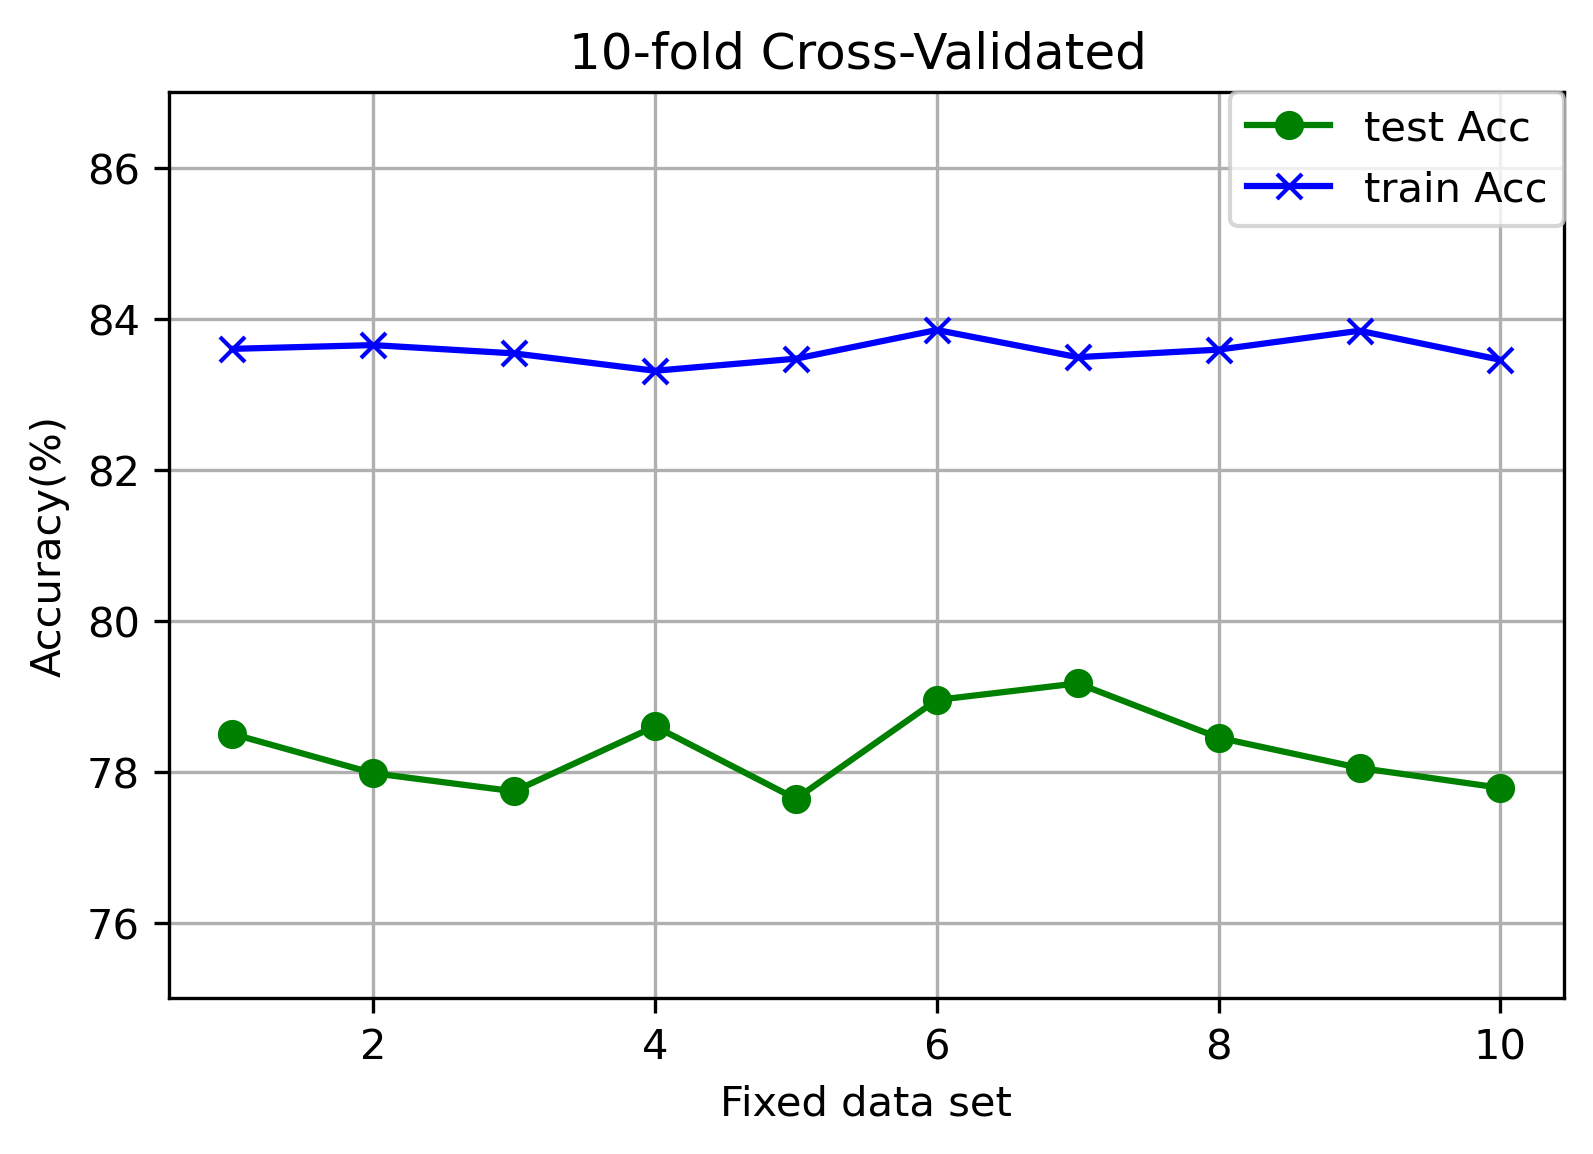

In [9]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(dpi=300)

ax.set_ylim([75,87])

plt.title("10-fold Cross-Validated ")
plt.xlabel('Fixed data set')
plt.ylabel('Accuracy(%)')

plt.plot(range(1,11),list(np.array(cv_acc_list)*100),'g-o',label="test Acc")
plt.plot(range(1,11),list(np.array(cv_acc_list_train)*100),'b-x',label="train Acc")

plt.grid(True)
plt.legend(bbox_to_anchor=(1.0, 1), loc=1, borderaxespad=0.)

plt.show()

#### evaluate¶

In [8]:
# best iter
s = 7
kernel = NeighborhoodHash

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.svm import SVC
### 1.Assign training & validation set
# (1).fix one set for validation
x_test = globals()[f'sub{s}'].Graph
y_test = globals()[f'sub{s}'].Label

# (2).nine set for training
train = pd.concat([eval(f'sub{n}') for n in range(1,11) if n != s],axis=0).reset_index(drop=True)
x_train = train.Graph
y_train = train.Label

### 2.10 iterations of training
# (1).Use the "shortest path kernel" to generate kernel matrices
gk1 = kernel(normalize=True)
K1_train = gk1.fit_transform(x_train)
K1_test = gk1.transform(x_test)

# (2).Using SVM classifier for classification
clf = SVC(kernel="precomputed")
clf.fit(K1_train, y_train)
y_pred = clf.predict(K1_test)
y_score = clf.fit(K1_train, y_train).decision_function(K1_test)

# (3).caculate classification accuracy
acc = accuracy_score(y_test, y_pred)

# (4).train predict 
y_pred_train = clf.predict(K1_train)
acc_train = accuracy_score(y_train, y_pred_train)

print(f"{s} iter Accuracy(train,test):", str(round(acc_train*100, 2)) + "%", str(round(acc*100, 2)) + "%")


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


7 iter Accuracy(train,test): 83.48% 78.9%


##### Prediction error

In [9]:
globals()[f'sub{s}']['Pre_Label'] = y_pred
# View predicted wrongly Labels
NH_pre_err = globals()[f'sub{s}'].loc[globals()[f'sub{s}'].Label != globals()[f'sub{s}'].Pre_Label,['Sent','Gene1_loc','Gene2_loc','Label','Pre_Label']]

In [10]:
#save
%cd /home/tku_stat_dell/Desktop/DS_corpus/predict_error
NH_pre_err.to_pickle('NH_pre_err.pkl')

/home/tku_stat_dell/Desktop/DS_corpus/predict_error


In [ ]:
#load
%cd /home/tku_stat_dell/Desktop/DS_corpus/predict_error
NH_pre_err = pd.read_pickle('NH_pre_err.pkl')

##### confusion matrix

[Text(0, 0.5, 'KEGG_Interaction'), Text(0, 1.5, 'NON_KEGG_Interaction')]

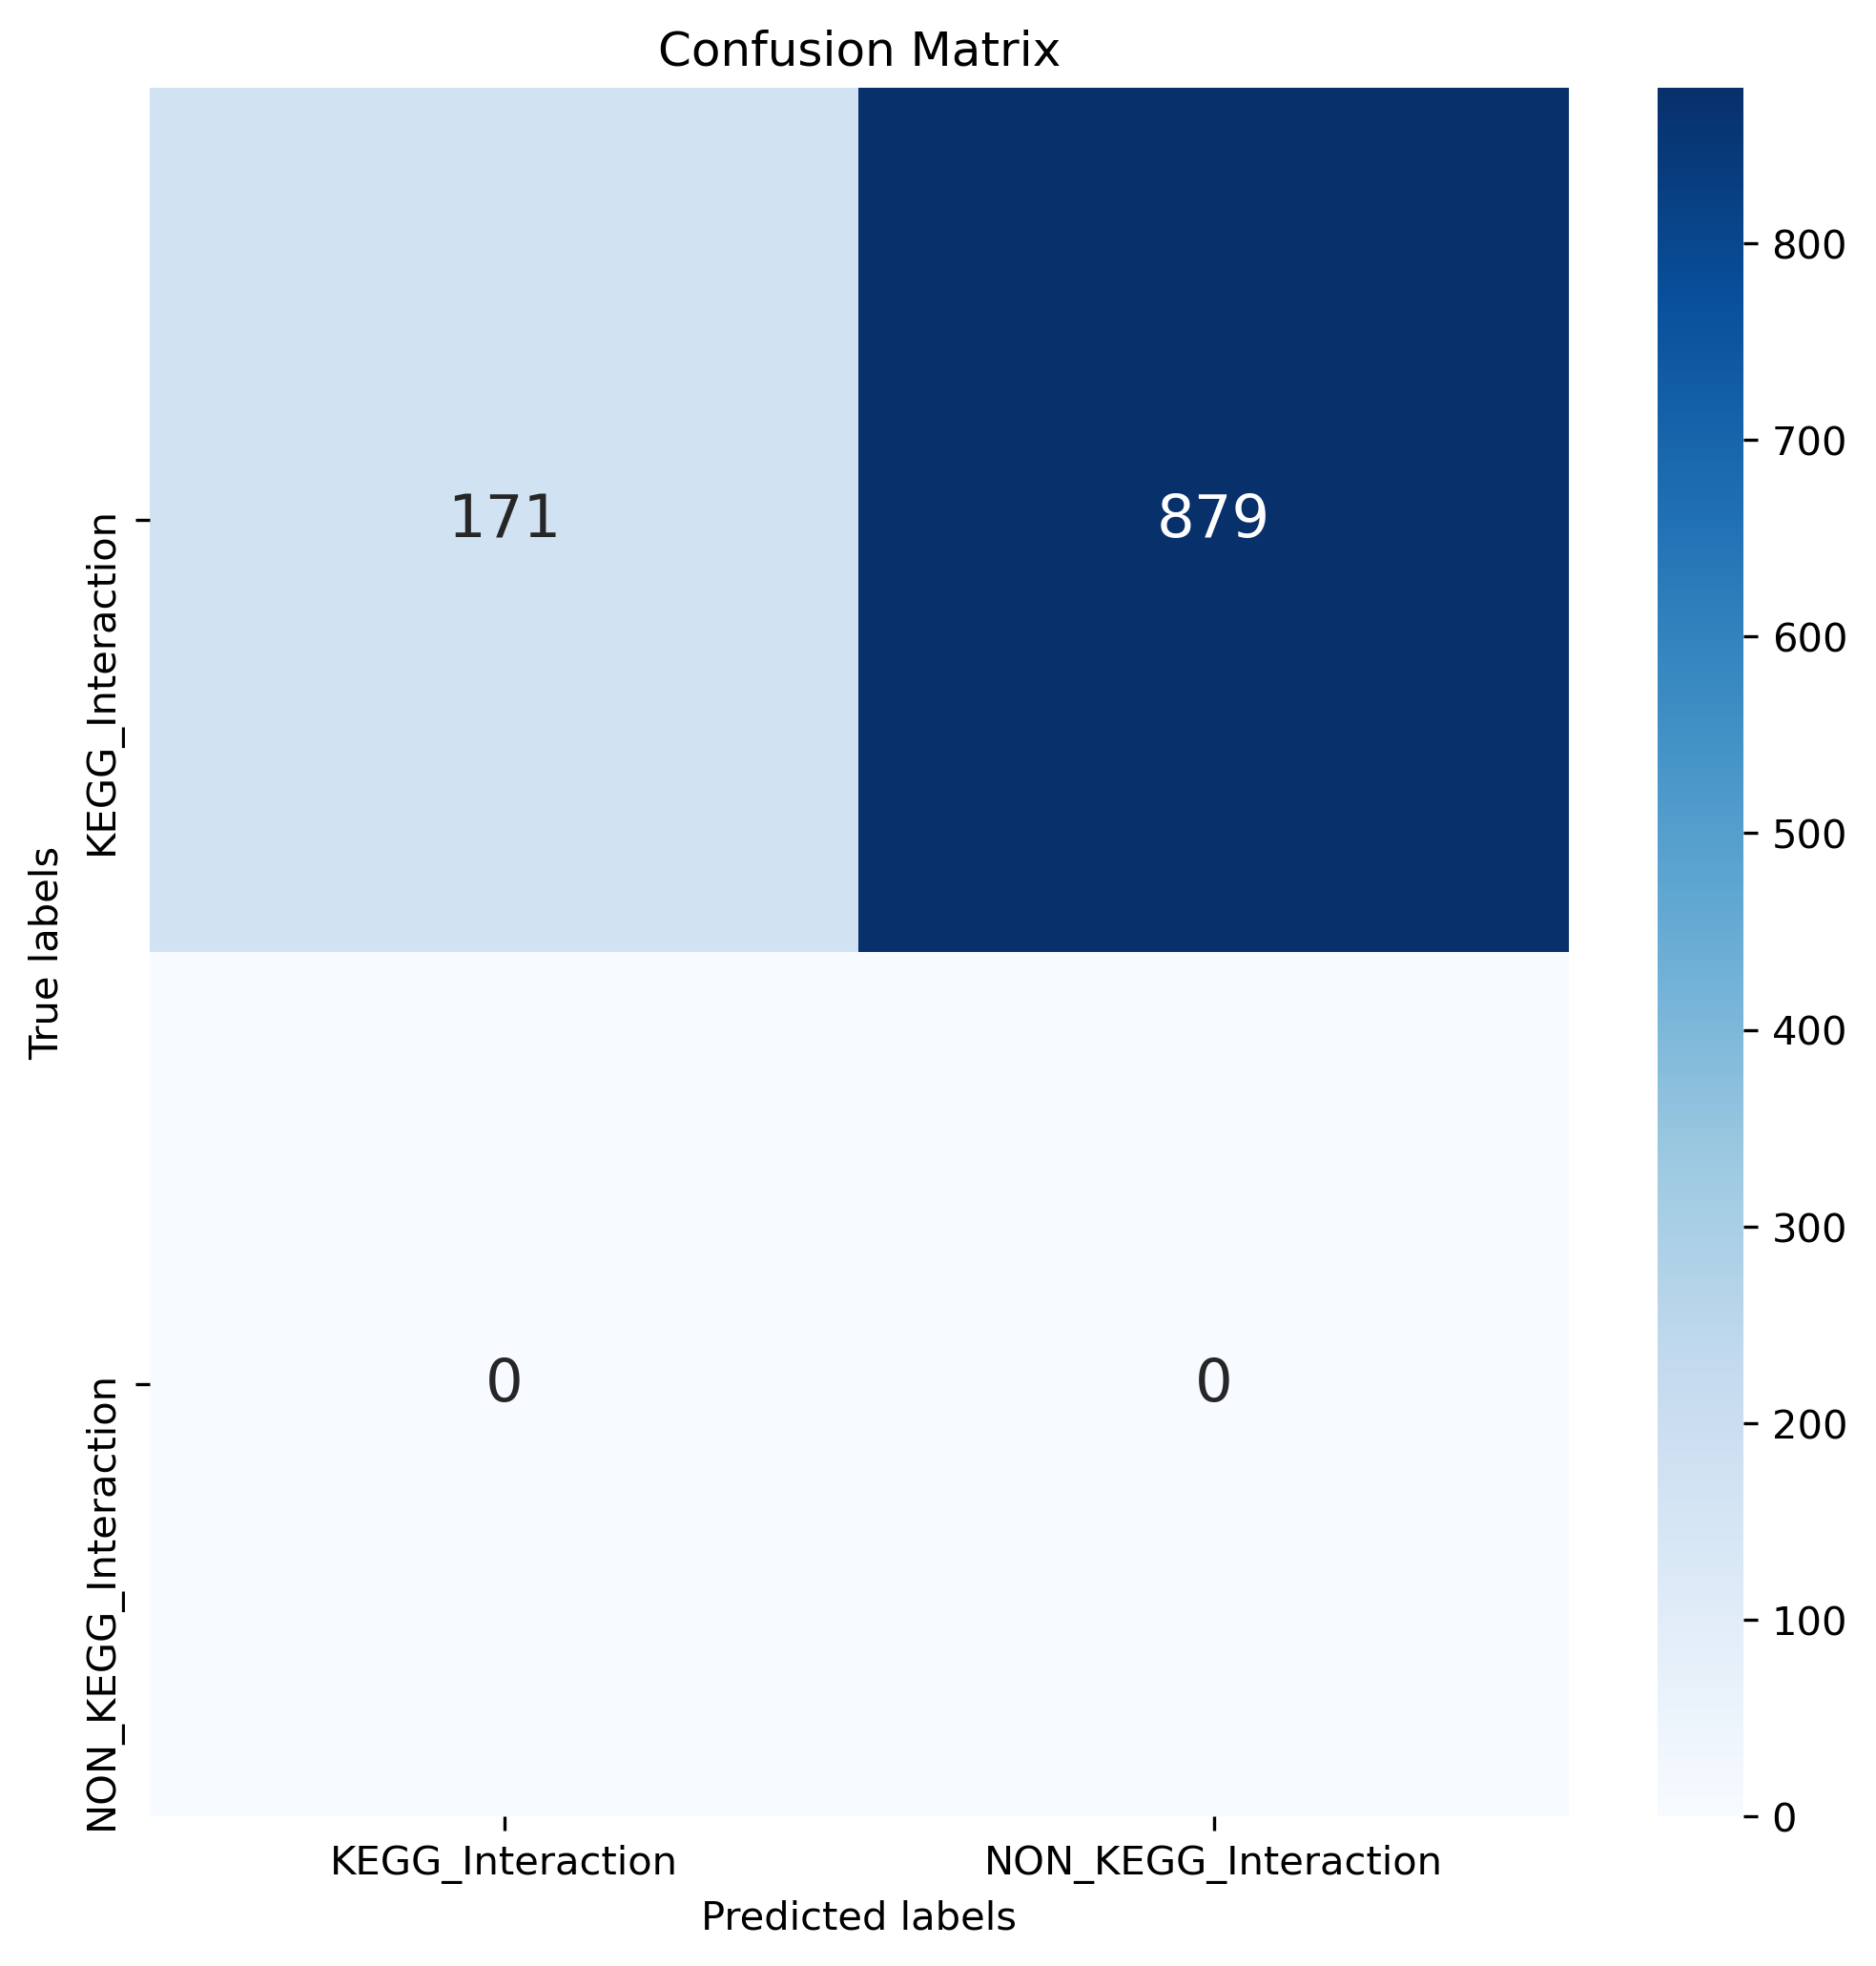

In [76]:
## 1.confusion matrix
cm = confusion_matrix(y_validation,y_pred)

fig, ax = plt.subplots(figsize=(8,8),dpi=300)
sns.heatmap(cm,annot=True, annot_kws={"size": 15},cmap='Blues', fmt='g')
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(["KEGG_Interaction", "NON_KEGG_Interaction"]) 
ax.yaxis.set_ticklabels(["KEGG_Interaction", "NON_KEGG_Interaction"])

##### precision, recall, f1-score

In [78]:
## 2.precision, recall, f1-score
#Official documents : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
#Interpret the results : https://www.libinx.com/2018/understanding-sklearn-classification-report/

print(classification_report(y_validation, y_pred, ['KEGG_Interaction','NON_KEGG_Interaction']))

                      precision    recall  f1-score   support

    KEGG_Interaction       1.00      0.16      0.28      1050
NON_KEGG_Interaction       0.00      0.00      0.00         0

            accuracy                           0.16      1050
           macro avg       0.50      0.08      0.14      1050
        weighted avg       1.00      0.16      0.28      1050



/home/tku_stat_dell/anaconda3/envs/tsai/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=['KEGG_Interaction', 'NON_KEGG_Interaction'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/tku_stat_dell/anaconda3/envs/tsai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tku_stat_dell/anaconda3/envs/tsai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home

##### ROC-AUC curve¶

/home/tku_stat_dell/anaconda3/envs/tsai/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:951: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


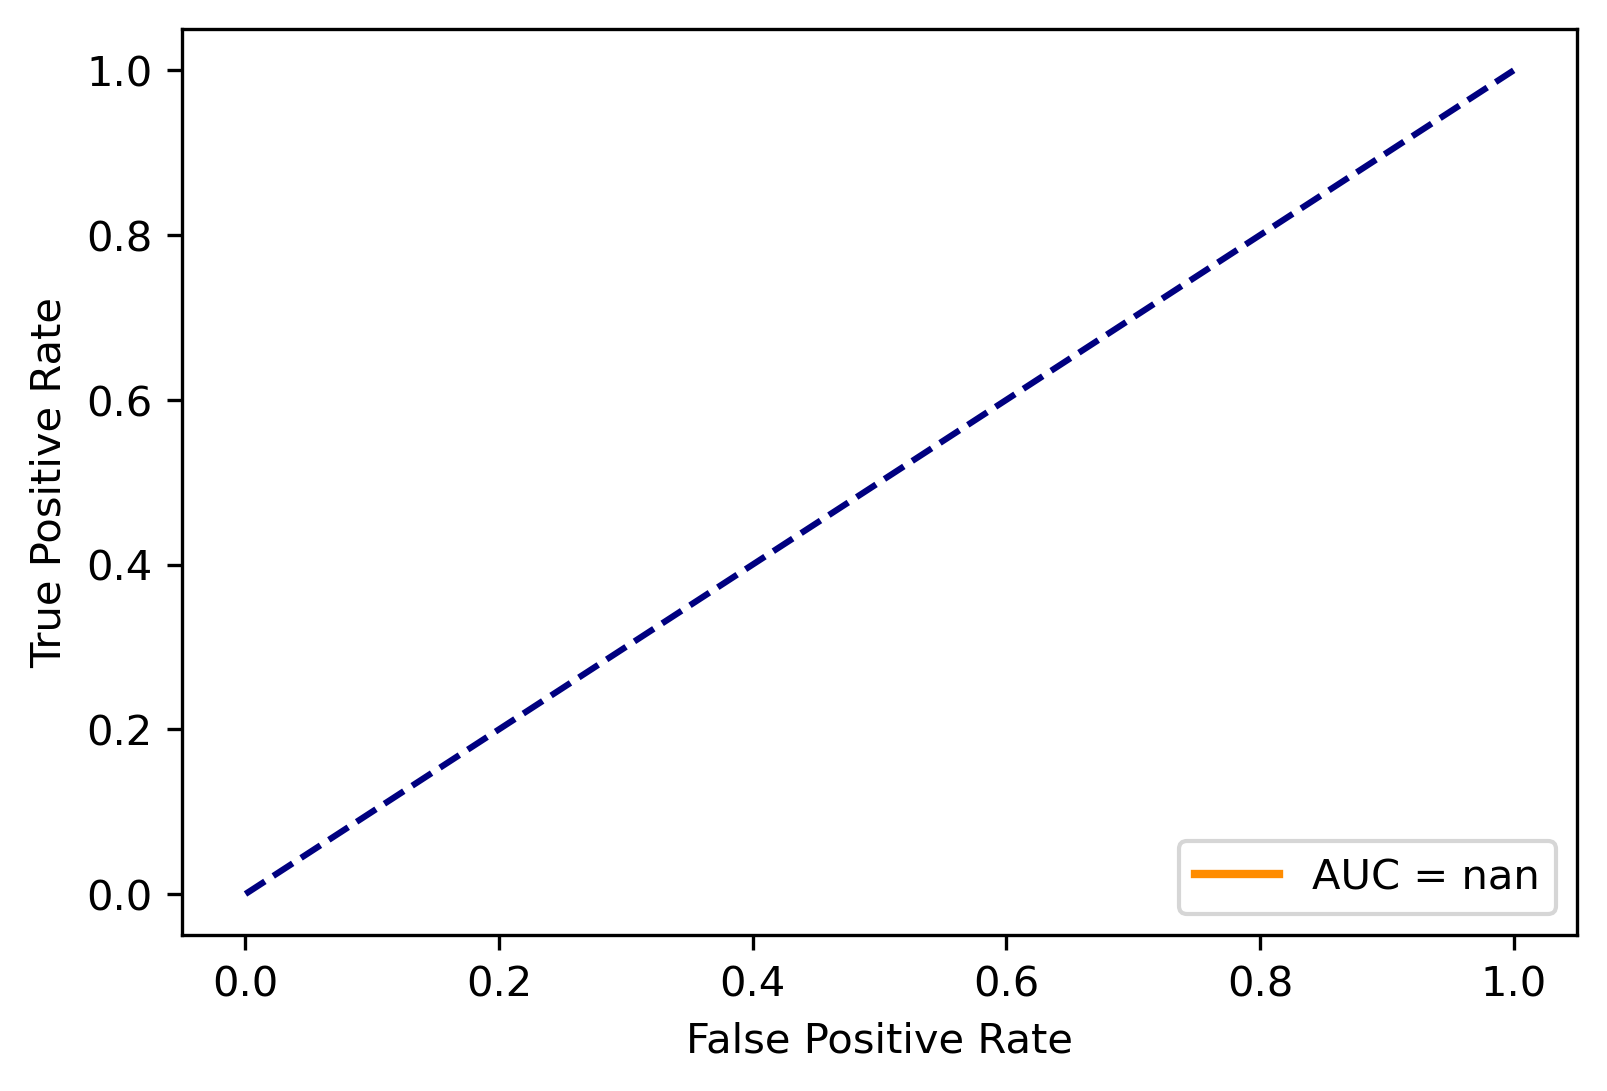

In [79]:
## 3.ROC-AUC curve
y_test_bool = np.asarray(list(map(int,[x=='NON_KEGG_Interaction' for x in y_validation])))+1
plotROC_AUC(y_test_bool, y_score)

### Propagation kernel

#### classifier example

In [ ]:
from grakel.kernels import Propagation

In [ ]:
# one iter
k_fold_fast(1,Propagation)

#### 10 fold cross-validation

In [ ]:
cv_acc_list = []
cv_acc_list_train = []
for s in range(1,11):
    acc = k_fold_fast(s,Propagation)
    cv_acc_list_train.append(acc[0])
    cv_acc_list.append(acc[1])

In [ ]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(dpi=300)

ax.set_ylim([75,80])

plt.title("10-fold Cross-Validated ")
plt.xlabel('Fixed data set')
plt.ylabel('Accuracy(%)')

plt.plot(range(1,11),list(np.array(cv_acc_list)*100),'g-o',label="test Acc")
plt.plot(range(1,11),list(np.array(cv_acc_list_train)*100),'b-x',label="train Acc")

plt.grid(True)
plt.legend(bbox_to_anchor=(1.0, 1), loc=1, borderaxespad=0.)

plt.show()

#### evaluate

In [ ]:
# best iter
s = 7
kernel = Propagation
### 1.Assign training & validation set
# (1).fix one set for validation
x_test = globals()[f'sub{s}'].Graph
y_test = globals()[f'sub{s}'].Label

# (2).nine set for training
train = pd.concat([eval(f'sub{n}') for n in range(1,11) if n != s],axis=0).reset_index(drop=True)
x_train = train.Graph
y_train = train.Label

### 2.10 iterations of training
# (1).Use the "shortest path kernel" to generate kernel matrices
gk1 = kernel(normalize=True)
K1_train = gk1.fit_transform(x_train)
K1_test = gk1.transform(x_test)

# (2).Using SVM classifier for classification
clf = SVC(kernel="precomputed")
clf.fit(K1_train, y_train)
y_pred = clf.predict(K1_test)
y_score = clf.fit(K1_train, y_train).decision_function(K1_test)

# (3).caculate classification accuracy
acc = accuracy_score(y_test, y_pred)

# (4).train predict 
y_pred_train = clf.predict(K1_train)
acc_train = accuracy_score(y_train, y_pred_train)

print(f"{s} iter Accuracy(train,test):", str(round(acc_train*100, 2)) + "%", str(round(acc*100, 2)) + "%")


##### Prediction error

In [ ]:
globals()[f'sub{s}']['Pre_Label'] = y_pred
# View predicted wrongly Labels
NSPD_pre_err = globals()[f'sub{s}'].loc[globals()[f'sub{s}'].Label != globals()[f'sub{s}'].Pre_Label,['Sent','Gene1_loc','Gene2_loc','Label','Pre_Label']]

In [ ]:
#save
%cd /home/tku_stat_dell/Desktop/DS_corpus/predict_error
NSPD_pre_err.to_pickle('NSPD_pre_err.pkl')

In [ ]:
#load
%cd /home/tku_stat_dell/Desktop/DS_corpus/predict_error
NSPD_pre_err = pd.read_pickle('NSPD_pre_err.pkl')

##### confusion matrix

In [ ]:
## 1.confusion matrix
cm = confusion_matrix(y_test,y_pred)

fig, ax = plt.subplots(figsize=(8,8),dpi=300)
sns.heatmap(cm,annot=True, annot_kws={"size": 15},cmap='Blues', fmt='g')
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(["KEGG_Interaction", "NON_KEGG_Interaction"]) 
ax.yaxis.set_ticklabels(["KEGG_Interaction", "NON_KEGG_Interaction"])

##### precision, recall, f1-score

In [ ]:
## 2.precision, recall, f1-score
#Official documents : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
#Interpret the results : https://www.libinx.com/2018/understanding-sklearn-classification-report/

print(classification_report(y_test, y_pred, ['KEGG_Interaction','NON_KEGG_Interaction']))

##### ROC-AUC curve

In [ ]:
## 3.ROC-AUC curve
y_test_bool = np.asarray(list(map(int,[x=='NON_KEGG_Interaction' for x in y_test])))+1
plotROC_AUC(y_test_bool, y_score)